Process the dataset.

Choose several protected attributes to analyze bias.

Use one-hot encoding to encode categorical variables.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('compas-scores-two-years.csv')

print(df['age_cat'].unique())
print(df['sex'].unique())
print(df['race'].unique())
print(df['priors_count'].unique())
print(df['c_charge_degree'].unique())

use_df = df[['sex','age_cat','race',
            'juv_fel_count','juv_misd_count','juv_other_count','priors_count',
            'c_charge_degree', 'decile_score', 'v_decile_score', 'score_text', 'v_score_text', 'is_recid', 'is_violent_recid']]

print(use_df.shape)
print(use_df.columns)
print(use_df.head())
# print(use_df['race'].unique())

# Encode all categorical variables in one step
categorical_columns = ['sex', 'age_cat', 'c_charge_degree'] #, 'score_text', 'v_score_text']
encoded_df = pd.get_dummies(use_df, columns=categorical_columns, drop_first=True)

# Now encode race separately without dropping any category
encoded_df = pd.get_dummies(encoded_df, columns=['race'], drop_first=False)

# Create mapping dictionary for score encoding
score_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

encoded_df['score_text'] = encoded_df['score_text'].map(score_mapping)
encoded_df['v_score_text'] = encoded_df['v_score_text'].map(score_mapping)

print("\nShape after encoding:", encoded_df.shape)
print("\nNew columns after encoding:")
print(encoded_df.columns)
print("\nFirst few rows of encoded data:")
print(encoded_df.head())


['Greater than 45' '25 - 45' 'Less than 25']
['Male' 'Female']
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']
[ 0  4  1  2 14  3  7  6  5 13  8  9 21 20 15 10 12 28 19 11 22 23 25 24
 36 18 16 33 17 30 27 38 26 37 29 35 31]
['F' 'M']
(7214, 14)
Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'decile_score',
       'v_decile_score', 'score_text', 'v_score_text', 'is_recid',
       'is_violent_recid'],
      dtype='object')
    sex          age_cat              race  juv_fel_count  juv_misd_count  \
0  Male  Greater than 45             Other              0               0   
1  Male          25 - 45  African-American              0               0   
2  Male     Less than 25  African-American              0               0   
3  Male     Less than 25  African-American              0               1   
4  Male          25 - 45             Other              0               0   

Try Random Forest Classifier, for both risk score and violence score.

In [12]:
from sklearn.metrics import classification_report

X = encoded_df.drop(columns=['decile_score', 'v_decile_score', 'score_text', 'v_score_text', 'is_recid', 'is_violent_recid'])
class_y = encoded_df['score_text']
v_class_y = encoded_df['v_score_text']

X_train, X_test, y_train_decile, y_test_decile, y_train_v_decile, y_test_v_decile = train_test_split(
    X, class_y, v_class_y, test_size=0.3, random_state=42
)

# Train models
clf_decile = RandomForestClassifier(random_state=42)
clf_decile.fit(X_train, y_train_decile)

clf_v_decile = RandomForestClassifier(random_state=42)
clf_v_decile.fit(X_train, y_train_v_decile)

# Make predictions
y_pred_decile = clf_decile.predict(X_test)
y_pred_v_decile = clf_v_decile.predict(X_test)

# Evaluate using classification metrics
print("Classification Report for Risk Score:")
print(classification_report(y_test_decile, y_pred_decile))

print("\nClassification Report for Violence Score:")
print(classification_report(y_test_v_decile, y_pred_v_decile))

Classification Report for Risk Score:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77      1176
           1       0.38      0.28      0.32       563
           2       0.58      0.38      0.46       426

    accuracy                           0.62      2165
   macro avg       0.55      0.51      0.52      2165
weighted avg       0.59      0.62      0.59      2165


Classification Report for Violence Score:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1428
           1       0.55      0.51      0.53       529
           2       0.40      0.21      0.28       208

    accuracy                           0.73      2165
   macro avg       0.59      0.54      0.55      2165
weighted avg       0.71      0.73      0.72      2165



Try XGBoost Classifier, for both risk score and violence score.

In [13]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Split the data into features and target variables
X = encoded_df.drop(columns=['decile_score', 'v_decile_score', 'score_text', 'v_score_text', 'is_recid', 'is_violent_recid'])
class_y = encoded_df['score_text']
v_class_y = encoded_df['v_score_text']

# Create label encoders
le = LabelEncoder()
y_encoded = le.fit_transform(class_y)
v_y_encoded = le.fit_transform(v_class_y)

# Split into train and test sets
X_train, X_test, y_train_decile, y_test_decile = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

# Define parameter grid for GridSearch
param_grid = {
    'max_depth': [3],              # Tree depth
    'learning_rate': [0.1],   # Learning rate
    'n_estimators': [200],         # Number of trees
    'min_child_weight': [1],
    'gamma': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'objective': ['multi:softprob'],
    'num_class': [3]               # Number of classes (Low, Medium, High)
}

# Initialize XGBoost model
xgb = XGBClassifier(
    random_state=42,
    objective='multi:softprob',
    num_class=3
)

# Perform GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit the model for risk score prediction
print("Training XGBoost for risk score prediction...")
grid_search.fit(X_train, y_train_decile)

# Get best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print("\nBest cross-validation score:", grid_search.best_score_)

# Use best model to make predictions
best_model = grid_search.best_estimator_
y_pred_encoded = best_model.predict(X_test)

# Convert predictions back to original labels
y_pred = le.inverse_transform(y_pred_encoded)
y_test_original = le.inverse_transform(y_test_decile)

# Print classification report
print("\nClassification Report for Risk Score:")
print(classification_report(y_test_original, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Training XGBoost for risk score prediction...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters found:
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'num_class': 3, 'objective': 'multi:softprob', 'subsample': 1.0}

Best cross-validation score: 0.6042715276481642

Classification Report for Risk Score:
              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1176
           1       0.43      0.35      0.38       563
           2       0.65      0.38      0.48       426

    accuracy                           0.65      2165
   macro avg       0.60      0.54      0.55      2165
weighted avg       0.63      0.65      0.62      2165


Top 10 Most Important Features:
                    feature  importance
6      age_cat_Less than 25    0.263055
8     race_African-American    0.185007
3              priors_count    0.144389
5   age_cat_Greater th

Use XGBoost Classifier, for both recidivism and violent recidivism. - binary classification.

In [14]:
# Split the data into features and target variables
X = encoded_df.drop(columns=['decile_score', 'v_decile_score', 'score_text', 'v_score_text', 'is_recid', 'is_violent_recid'])
class_y = encoded_df['is_recid']  # Binary target (0 or 1)
v_class_y = encoded_df['is_violent_recid']

# Create label encoders
le = LabelEncoder()
y_encoded = le.fit_transform(class_y)
v_y_encoded = le.fit_transform(v_class_y)

# Split into train and test sets - do this separately for each target
X_train, X_test, y_train_decile, y_test_decile = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)

# For violent recidivism, use the same split indices
_, _, v_y_train, v_y_test = train_test_split(
    X, v_y_encoded, test_size=0.3, random_state=42
)

# Define parameter grid
param_grid = {
    'max_depth': [3],              
    'learning_rate': [0.1],   
    'n_estimators': [200],         
    'min_child_weight': [1],
    'gamma': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'objective': ['binary:logistic']
}

# Train and evaluate for regular recidivism
print("\n=== Regular Recidivism Prediction ===")
xgb_recid = XGBClassifier(random_state=42, objective='binary:logistic')
grid_search_recid = GridSearchCV(
    estimator=xgb_recid,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("Training XGBoost for recidivism prediction...")
grid_search_recid.fit(X_train, y_train_decile)

print("\nBest parameters found:")
print(grid_search_recid.best_params_)
print("\nBest cross-validation score:", grid_search_recid.best_score_)

# Make predictions and evaluate
y_pred_recid = grid_search_recid.best_estimator_.predict(X_test)
print("\nClassification Report for Recidivism Prediction:")
print(classification_report(y_test_decile, y_pred_recid))

# Feature importance for recidivism
feature_importance_recid = pd.DataFrame({
    'feature': X.columns,
    'importance': grid_search_recid.best_estimator_.feature_importances_
})
feature_importance_recid = feature_importance_recid.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features for Recidivism:")
print(feature_importance_recid.head(10))

# Train and evaluate for violent recidivism
print("\n\n=== Violent Recidivism Prediction ===")
xgb_violent = XGBClassifier(random_state=42, objective='binary:logistic')
grid_search_violent = GridSearchCV(
    estimator=xgb_violent,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

print("Training XGBoost for violent recidivism prediction...")
grid_search_violent.fit(X_train, v_y_train)

print("\nBest parameters found:")
print(grid_search_violent.best_params_)
print("\nBest cross-validation score:", grid_search_violent.best_score_)

# Make predictions and evaluate
y_pred_violent = grid_search_violent.best_estimator_.predict(X_test)
print("\nClassification Report for Violent Recidivism Prediction:")
print(classification_report(v_y_test, y_pred_violent))

# Feature importance for violent recidivism
feature_importance_violent = pd.DataFrame({
    'feature': X.columns,
    'importance': grid_search_violent.best_estimator_.feature_importances_
})
feature_importance_violent = feature_importance_violent.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features for Violent Recidivism:")
print(feature_importance_violent.head(10))


=== Regular Recidivism Prediction ===
Training XGBoost for recidivism prediction...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters found:
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 1.0}

Best cross-validation score: 0.6483384017009722

Classification Report for Recidivism Prediction:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1153
           1       0.67      0.66      0.67      1012

    accuracy                           0.69      2165
   macro avg       0.69      0.69      0.69      2165
weighted avg       0.69      0.69      0.69      2165


Top 10 Most Important Features for Recidivism:
                    feature  importance
6      age_cat_Less than 25    0.273978
3              priors_count    0.226027
5   age_cat_Greater than 45    0.149772
4                  sex_Mal

In [15]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
import numpy as np

# First, create functions to help with the analysis
def create_aif_dataset(X, y, protected_attribute_names, favorable_label=1, unfavorable_label=0):
    """
    Create an AIF360 BinaryLabelDataset from features and labels
    """
    df = pd.concat([X, pd.Series(y, index=X.index)], axis=1)
    return BinaryLabelDataset(
        df=df,
        label_names=[df.columns[-1]],  # last column is the label
        protected_attribute_names=protected_attribute_names,
        favorable_label=favorable_label,
        unfavorable_label=unfavorable_label
    )

def compute_fairness_metrics(dataset, privileged_groups, unprivileged_groups):
    """
    Compute fairness metrics for a dataset
    """
    metrics = BinaryLabelDatasetMetric(
        dataset,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print("Disparate Impact:", metrics.disparate_impact())
    print("Statistical Parity Difference:", metrics.statistical_parity_difference())
    # print("Equalized Odds Difference:", metrics.equalized_odds_difference())
    # print("Equal Opportunity Difference:", metrics.equal_opportunity_difference())
    
def compute_classification_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups):
    """
    Compute classification fairness metrics
    """
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    print("Equal Opportunity Difference:", metrics.equal_opportunity_difference())
    print("Average Odds Difference:", metrics.average_odds_difference())
    print("Disparate Impact:", metrics.disparate_impact())
    print("Statistical Parity Difference:", metrics.statistical_parity_difference())
    print("Equalized Odds Difference:", metrics.equalized_odds_difference())
    # print("Positive Predictive Value:", metrics.positive_predictive_value())
    # print("True Positive Rate Difference:", metrics.true_positive_rate_difference())
    # print("False Positive Rate Difference:", metrics.false_positive_rate_difference())
    print("===== Privileged Group Metrics =====")
    print("TPR: ", metrics.true_positive_rate(privileged=True))
    print("FPR: ", metrics.false_positive_rate(privileged=True))
    print("TNR: ", metrics.true_negative_rate(privileged=True))
    print("FNR: ", metrics.false_negative_rate(privileged=True))
    print("PPV: ", metrics.positive_predictive_value(privileged=True))
    print("===== Unprivileged Group Metrics =====")
    print("TPR: ", metrics.true_positive_rate(privileged=False))
    print("FPR: ", metrics.false_positive_rate(privileged=False))
    print("TNR: ", metrics.true_negative_rate(privileged=False))
    print("FNR: ", metrics.false_negative_rate(privileged=False))
    print("PPV: ", metrics.positive_predictive_value(privileged=False))

# Analyze fairness for different protected attributes
print("\n=== Fairness Analysis ===")

# 1. Race Analysis
protected_attribute_names_race = ['race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other']
privileged_groups_race = [{'race_Caucasian': 1}, {'race_Hispanic': 1}]
unprivileged_groups_race = [
    {'race_African-American': 1},
    {'race_Asian': 1},
    # {'race_Hispanic': 1},
    {'race_Native American': 1},
    {'race_Other': 1}
]

# Create datasets for true values and predictions
dataset_true = create_aif_dataset(X_test, y_test_decile, protected_attribute_names_race)
dataset_pred = create_aif_dataset(X_test, y_pred_recid, protected_attribute_names_race)

print("\nRace Fairness Metrics:")
print("Original dataset metrics:")
compute_fairness_metrics(dataset_true, privileged_groups_race, unprivileged_groups_race)
print("\nPrediction metrics:")
compute_classification_metrics(dataset_true, dataset_pred, privileged_groups_race, unprivileged_groups_race)

# 2. Sex Analysis
protected_attribute_names_sex = ['sex_Male']
privileged_groups_sex = [{'sex_Male': 0}]
unprivileged_groups_sex = [{'sex_Male': 1}]

dataset_true = create_aif_dataset(X_test, y_test_decile, protected_attribute_names_sex)
dataset_pred = create_aif_dataset(X_test, y_pred_recid, protected_attribute_names_sex)

print("\nSex Fairness Metrics:")
print("Original dataset metrics:")
compute_fairness_metrics(dataset_true, privileged_groups_sex, unprivileged_groups_sex)
print("\nPrediction metrics:")
compute_classification_metrics(dataset_true, dataset_pred, privileged_groups_sex, unprivileged_groups_sex)

# 3. Age Analysis
protected_attribute_names_age = ['age_cat_Greater than 45', 'age_cat_Less than 25']
privileged_groups_age = [{'age_cat_Greater than 45': 1}]
unprivileged_groups_age = [
    {'age_cat_Less than 25': 1}, 
    # {'age_cat_Greater than 45': 0, 'age_cat_Less than 25': 0}  # Group for 25-45 years
]

# Create datasets for true values and predictions
dataset_true = create_aif_dataset(X_test, y_test_decile, protected_attribute_names_age)
dataset_pred = create_aif_dataset(X_test, y_pred_recid, protected_attribute_names_age)

print("\nAge Fairness Metrics:")
print("Original dataset metrics:")
compute_fairness_metrics(dataset_true, privileged_groups_age, unprivileged_groups_age)
print("\nPrediction metrics:")
compute_classification_metrics(dataset_true, dataset_pred, privileged_groups_age, unprivileged_groups_age)


=== Fairness Analysis ===

Race Fairness Metrics:
Original dataset metrics:
Disparate Impact: 1.3873652566225543
Statistical Parity Difference: 0.14814727582639403

Prediction metrics:
Equal Opportunity Difference: 0.2767348588083069
Average Odds Difference: 0.23412289869487596
Disparate Impact: 1.9552412190788575
Statistical Parity Difference: 0.2804662734240199
Equalized Odds Difference: 0.2767348588083069
===== Privileged Group Metrics =====
TPR:  0.47592067988668557
FPR:  0.18070175438596492
TNR:  0.8192982456140351
FNR:  0.5240793201133145
PPV:  0.6199261992619927
===== Unprivileged Group Metrics =====
TPR:  0.7526555386949925
FPR:  0.37221269296740994
TNR:  0.62778730703259
FNR:  0.2473444613050076
PPV:  0.6956521739130435

Sex Fairness Metrics:
Original dataset metrics:
Disparate Impact: 1.3426392572944297
Statistical Parity Difference: 0.1251453206742879

Prediction metrics:
Equal Opportunity Difference: 0.298961937716263
Average Odds Difference: 0.23057692925486883
Disparate 

=== Interpretation of Metrics ===

1. Disparate Impact: A value of 1.0 means both groups are treated equally
   - Values < 1 indicate negative impact on unprivileged group
   - Values > 1 indicate positive impact on unprivileged group

2. Statistical Parity Difference: Should be close to 0 for fairness
   - Positive values indicate higher selection rate for privileged group
   - Negative values indicate higher selection rate for unprivileged group

3. Equal Opportunity Difference: Should be close to 0 for fairness
   - Measures difference in true positive rates between groups

4. Average Odds Difference: Should be close to 0 for fairness
   - Measures average of difference in false positive rates and true positive rates

=== Extended Interpretation of Metrics ===

1. Basic Fairness Metrics:
   - Disparate Impact (DI): Ratio of positive outcome rates (unprivileged/privileged)
     • DI = 1.0: Equal treatment
     • DI < 1.0: Negative impact on unprivileged group
     • DI > 1.0: Positive impact on unprivileged group

   - Statistical Parity Difference (SPD): Difference in selection rates
     • SPD = 0: Equal selection rates
     • SPD > 0: Higher selection rate for privileged group
     • SPD < 0: Higher selection rate for unprivileged group

   - Equal Opportunity Difference (EOD): Difference in true positive rates
     • EOD = 0: Equal true positive rates
     • Measures fairness for positive outcomes

   - Average Odds Difference (AOD): Average of TPR and FPR differences
     • AOD = 0: Equal prediction rates
     • Measures overall prediction fairness

2. Classification Performance Metrics:
   - True Positive Rate (TPR) or Sensitivity or Recall
     • TPR = TP / (TP + FN)
     • Proportion of actual positive cases correctly identified
     • Higher is better
     • Example: Percentage of actual high-risk individuals correctly identified

   - False Positive Rate (FPR)
     • FPR = FP / (FP + TN)
     • Proportion of actual negative cases incorrectly identified as positive
     • Lower is better
     • Example: Percentage of low-risk individuals incorrectly classified as high-risk

   - True Negative Rate (TNR) or Specificity
     • TNR = TN / (TN + FP)
     • Proportion of actual negative cases correctly identified
     • Higher is better
     • Example: Percentage of low-risk individuals correctly identified

   - False Negative Rate (FNR)
     • FNR = FN / (FN + TP)
     • Proportion of actual positive cases incorrectly identified as negative
     • Lower is better
     • Example: Percentage of high-risk individuals incorrectly classified as low-risk

   - Positive Predictive Value (PPV) or Precision
     • PPV = TP / (TP + FP)
     • Proportion of positive predictions that are correct
     • Higher is better
     • Example: Percentage of predicted high-risk individuals who are actually high-risk

3. Fairness Implications:
   - For Criminal Justice Applications:
     • FPR: Critical metric as false positives mean wrongly identifying someone as high-risk
     • FNR: Important for public safety as false negatives mean missing high-risk individuals
     • PPV: Indicates reliability of high-risk predictions
     • Balance needed between public safety (low FNR) and individual rights (low FPR)

   - Group Fairness:
     • Similar TPR across groups: Equal opportunity
     • Similar FPR across groups: Equal treatment of negative cases
     • Similar PPV across groups: Equal reliability of positive predictions
     • Large differences in any metric suggest potential bias

4. Interpreting Group Differences:
   - TPR Difference > 0.1: Significant disparity in identifying positive cases
   - FPR Difference > 0.1: Significant disparity in false accusations
   - PPV Difference > 0.1: Significant disparity in prediction reliability
   - Consider both statistical and practical significance

5. Equalized Odds Difference:
   - Definition: 
     • Measures whether the model has equal TPR AND equal FPR across privileged and unprivileged groups
     • Combines both True Positive Rate and False Positive Rate differences
     • EOD = 0.5 * (TPR_diff + FPR_diff)
       where: TPR_diff = TPR_privileged - TPR_unprivileged
              FPR_diff = FPR_privileged - FPR_unprivileged

   - Interpretation:
     • EOD = 0: Perfect equalized odds (ideal case)
     • EOD > 0: Model favors privileged group
     • EOD < 0: Model favors unprivileged group

   - Key Differences from Other Metrics:
     • Equal Opportunity only considers TPR differences
     • Average Odds takes the average of TPR and FPR differences
     • Equalized Odds requires BOTH rates to be equal

   - Practical Significance:
     • Stricter than Equal Opportunity
     • Ensures fairness for both positive and negative cases
     • Important when both types of errors (FP and FN) are critical
     • |EOD| > 0.1 suggests significant bias in model predictions

   - Example in Risk Assessment:
     • EOD = 0: Model equally accurate for all groups
     • EOD > 0: Privileged group gets both:
       - More correct high-risk predictions (TPR)
       - More incorrect high-risk predictions (FPR)
     • EOD < 0: Unprivileged group experiences the above effects

   - Trade-offs:
     • Perfect equalized odds may come at cost of accuracy
     • May need to balance with other performance metrics
     • Consider domain-specific impact of different error types

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_tpr_fpr(y_true, y_pred, protected_groups):
    """
    Calculate TPR and FPR for each group.
    """
    for g in protected_groups:
        # Define group condition
        group_condition = np.all([X_test[attribute] == value for attribute, value in g.items()], axis=0)
        
        # Get the true and predicted labels for this group
        y_true_group = y_true[group_condition]
        y_pred_group = y_pred[group_condition]
        
        # Ensure binary classification by converting to 0/1
        y_true_binary = (y_true_group > 0).astype(int)
        y_pred_binary = (y_pred_group > 0).astype(int)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true_binary, y_pred_binary)
        if cm.shape == (2,2):  # Only proceed if we have a 2x2 matrix
            tn, fp, fn, tp = cm.ravel()
            
            # Calculate TPR and FPR
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            # Print results
            print(f"\nGroup: {g}")
            print(f"TPR (True Positive Rate): {tpr:.3f}")
            print(f"FPR (False Positive Rate): {fpr:.3f}")

# Update group list processing to avoid duplication:
# Race Analysis (privileged and unprivileged groups merged):
protected_groups_race = [
    {'race_Caucasian': 1}, 
    {'race_African-American': 1}, 
    {'race_Asian': 1}, 
    {'race_Hispanic': 1},
    {'race_Native American': 1}, 
    {'race_Other': 1}
]

# Sex Analysis (privileged and unprivileged groups merged):
protected_groups_sex = [
    {'sex_Male': 1}, 
    {'sex_Male': 0}
]

# Age Analysis (privileged and unprivileged groups merged):
protected_groups_age = [
    {'age_cat_Greater than 45': 1},
    {'age_cat_Less than 25': 1},
    {'age_cat_Greater than 45': 0, 'age_cat_Less than 25': 0}  # 25-45 group
]

# Race Fairness Analysis
print("\n=== Race TPR and FPR ===")
calculate_tpr_fpr(y_test_decile, y_pred_recid, protected_groups_race)

# Sex Fairness Analysis
print("\n=== Sex TPR and FPR ===")
calculate_tpr_fpr(y_test_decile, y_pred_recid, protected_groups_sex)

# Age Fairness Analysis
print("\n=== Age TPR and FPR ===")
calculate_tpr_fpr(y_test_decile, y_pred_recid, protected_groups_age)




=== Race TPR and FPR ===

Group: {'race_Caucasian': 1}
TPR (True Positive Rate): 0.500
FPR (False Positive Rate): 0.179

Group: {'race_African-American': 1}
TPR (True Positive Rate): 0.773
FPR (False Positive Rate): 0.401

Group: {'race_Asian': 1}
TPR (True Positive Rate): 0.500
FPR (False Positive Rate): 0.000

Group: {'race_Hispanic': 1}
TPR (True Positive Rate): 0.361
FPR (False Positive Rate): 0.189

Group: {'race_Native American': 1}
TPR (True Positive Rate): 1.000
FPR (False Positive Rate): 0.000

Group: {'race_Other': 1}
TPR (True Positive Rate): 0.477
FPR (False Positive Rate): 0.208

=== Sex TPR and FPR ===

Group: {'sex_Male': 1}
TPR (True Positive Rate): 0.699
FPR (False Positive Rate): 0.313

Group: {'sex_Male': 0}
TPR (True Positive Rate): 0.400
FPR (False Positive Rate): 0.151

=== Age TPR and FPR ===

Group: {'age_cat_Greater than 45': 1}
TPR (True Positive Rate): 0.464
FPR (False Positive Rate): 0.136

Group: {'age_cat_Less than 25': 1}
TPR (True Positive Rate): 0.767


In [17]:
dataset_pred.labels
dataset_true.labels


array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

In [18]:
def create_aif_dataset(X, y, protected_attribute_names):
    """
    Create an AIF360 BinaryLabelDataset with proper protected attributes
    """
    # Combine features and labels
    df = pd.concat([X[protected_attribute_names], pd.Series(y, name='label')], axis=1)
    
    # Handle NA values by filling them with 0
    df = df.fillna(0)
    
    # Convert all values to float64
    df = df.astype(np.float64)
    
    return BinaryLabelDataset(
        df=df,
        label_names=['label'],
        protected_attribute_names=protected_attribute_names,
        favorable_label=1,
        unfavorable_label=0
    )

# Define protected attributes
protected_attrs = {
    'race': ['race_African-American', 'race_Caucasian'],
    'sex': ['sex_Male'],
    'age': ['age_cat_Greater than 45', 'age_cat_Less than 25']
}

# First, check for NA values
print("Checking for NA values before processing:")
print(X_test[protected_attrs['race']].isna().sum())

# Create datasets for race analysis
dataset_true = create_aif_dataset(
    X_test, 
    y_test_decile,
    protected_attrs['race']
)
dataset_pred = create_aif_dataset(
    X_test, 
    y_pred_recid,
    protected_attrs['race']
)

# Calculate metrics
metrics = ClassificationMetric(
    dataset_true,
    dataset_pred,
    privileged_groups=[{'race_Caucasian': 1}],
    unprivileged_groups=[{'race_African-American': 1}]
)

# Print fairness metrics
print("\nFairness Metrics:")
print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")
print(f"Disparate Impact: {metrics.disparate_impact():.3f}")
print(f"Statistical Parity Difference: {metrics.statistical_parity_difference():.3f}")

Checking for NA values before processing:
race_African-American    0
race_Caucasian           0
dtype: int64

Fairness Metrics:
Equal Opportunity Difference: -0.099
Average Odds Difference: -0.047
Disparate Impact: 0.918
Statistical Parity Difference: -0.011


In [19]:
ClassificationMetric(dataset_true, dataset_pred, privileged_groups=[{'race_Caucasian': 1}], unprivileged_groups=[{'race_African-American': 1}])


In [20]:
from aif360.metrics import ClassificationMetric

def calculate_group_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups):
    """
    Calculate confusion matrix metrics using AIF360 for each group
    """
    metrics = ClassificationMetric(
        dataset_true,
        dataset_pred,
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups
    )
    
    # Get metrics for privileged group
    priv_metrics = {
        'TPR': metrics.true_positive_rate(privileged=True),
        'TNR': metrics.true_negative_rate(privileged=True),
        'FPR': metrics.false_positive_rate(privileged=True),
        'FNR': metrics.false_negative_rate(privileged=True)
    }
    
    # Get metrics for unprivileged group
    unpriv_metrics = {
        'TPR': metrics.true_positive_rate(privileged=False),
        'TNR': metrics.true_negative_rate(privileged=False),
        'FPR': metrics.false_positive_rate(privileged=False),
        'FNR': metrics.false_negative_rate(privileged=False)
    }
    
    print("\nPrivileged Group Metrics:")
    for metric, value in priv_metrics.items():
        print(f"{metric}: {value:.3f}")
    
    print("\nUnprivileged Group Metrics:")
    for metric, value in unpriv_metrics.items():
        print(f"{metric}: {value:.3f}")
    
    # Calculate disparities
    print("\nDisparities:")
    print(f"TPR Difference: {metrics.true_positive_rate_difference():.3f}")
    print(f"FPR Difference: {metrics.false_positive_rate_difference():.3f}")
    print(f"Equal Opportunity Difference: {metrics.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference: {metrics.average_odds_difference():.3f}")

# Define protected groups
protected_groups = {
    'race': {
        'privileged': [{'race_Caucasian': 1}],
        'unprivileged': [{'race_African-American': 1}]
    },
    'sex': {
        'privileged': [{'sex_Male': 1}],
        'unprivileged': [{'sex_Male': 0}]
    },
    'age': {
        'privileged': [{'age_cat_Greater than 45': 1}],
        'unprivileged': [{'age_cat_Less than 25': 1}]
    }
}


# Analyze each protected attribute
for attr, groups in protected_groups.items():
    print(f"\n=== {attr.capitalize()} Analysis ===")
    dataset_true = create_aif_dataset(X_test, y_test_decile, [list(groups['privileged'][0].keys())[0]])
    dataset_pred = create_aif_dataset(X_test, y_pred, [list(groups['privileged'][0].keys())[0]])
    
    calculate_group_metrics(
        dataset_true,
        dataset_pred,
        privileged_groups=groups['privileged'],
        unprivileged_groups=groups['unprivileged']
    )


=== Race Analysis ===


ValueError: The favorable and unfavorable labels provided do not match the labels in the dataset.

In [ ]:

# # 4. Priors Count Analysis (0 vs any priors)
# # First create binary feature for priors
# X_test_with_priors = X_test.copy()
# X_test_with_priors['no_priors'] = (X_test_with_priors['priors_count'] == 0).astype(int)

# protected_attribute_names = ['no_priors']
# privileged_groups = [{'no_priors': 1}]  # 0 priors is privileged group
# unprivileged_groups = [{'no_priors': 0}]  # having priors is unprivileged group

# dataset_true = create_aif_dataset(X_test_with_priors, y_test_decile, protected_attribute_names)
# dataset_pred = create_aif_dataset(X_test_with_priors, y_pred_recid, protected_attribute_names)

# print("\nPriors Count Fairness Metrics (0 vs any priors):")
# print("Original dataset metrics:")
# compute_fairness_metrics(dataset_true, privileged_groups, unprivileged_groups)
# print("\nPrediction metrics:")
# compute_classification_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups)

# # 5. Charge Degree Analysis (M vs F)
# protected_attribute_names = ['c_charge_degree_M']
# privileged_groups = [{'c_charge_degree_M': 0}]  # F charges are privileged group
# unprivileged_groups = [{'c_charge_degree_M': 1}]  # M charges are unprivileged group

# dataset_true = create_aif_dataset(X_test, y_test_decile, protected_attribute_names)
# dataset_pred = create_aif_dataset(X_test, y_pred_recid, protected_attribute_names)

# print("\nCharge Degree Fairness Metrics (M vs F):")
# print("Original dataset metrics:")
# compute_fairness_metrics(dataset_true, privileged_groups, unprivileged_groups)
# print("\nPrediction metrics:")
# compute_classification_metrics(dataset_true, dataset_pred, privileged_groups, unprivileged_groups)

In [47]:
# Cell 2: Race Fairness Analysis
print("\n=== Race Fairness Analysis ===")

# For African-American vs Caucasian
print_fairness_metrics(
    encoded_df,
    'race_Caucasian',
    'score_text',
    y_pred_recid,
    privileged_value=1,
    unprivileged_value=0,
    feature_name="Race (Caucasian vs Others)"
)

# You can also compare specific races
race_pairs = [
    ('race_African-American', 'race_Caucasian'),
    ('race_African-American', 'race_Hispanic'),
    ('race_Caucasian', 'race_Hispanic')
]

for race1, race2 in race_pairs:
    # Create temporary binary feature for comparison
    temp_df = encoded_df[encoded_df[race1] | encoded_df[race2]].copy()
    temp_df['temp_race'] = temp_df[race1].astype(int)
    
    print(f"\nComparing {race1} vs {race2}")
    print_fairness_metrics(
        temp_df,
        'temp_race',
        'score_text',
        y_pred_recid,
        privileged_value=1,
        unprivileged_value=0,
        feature_name=f"{race1} vs {race2}"
    )


=== Race Fairness Analysis ===

=== Fairness Metrics for Race (Caucasian vs Others) ===

Original dataset metrics:
Disparate Impact: 1.6379
Statistical Parity Difference: -0.2937


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2165 but corresponding boolean dimension is 7214


Analyzing bias in predictions...

Sex Bias Analysis:
  modification  high_risk_pct  medium_risk_pct  low_risk_pct
0     original      11.501155        21.247113     67.251732
1     sex_Male      11.454965        19.214781     69.330254

Race Bias Analysis:
            modification  high_risk_pct  medium_risk_pct  low_risk_pct
0               original      11.501155        21.247113     67.251732
1  race_African-American      12.609700        24.387991     63.002309
2             race_Asian       8.083141        22.678984     69.237875
3         race_Caucasian       9.376443        18.152425     72.471132
4          race_Hispanic       8.083141        13.487298     78.429561
5   race_Native American      10.715935        33.856813     55.427252
6             race_Other       9.376443         5.450346     85.173210

Age Bias Analysis:
              modification  high_risk_pct  medium_risk_pct  low_risk_pct
0                 original      11.501155        21.247113     67.251732
1  age_c

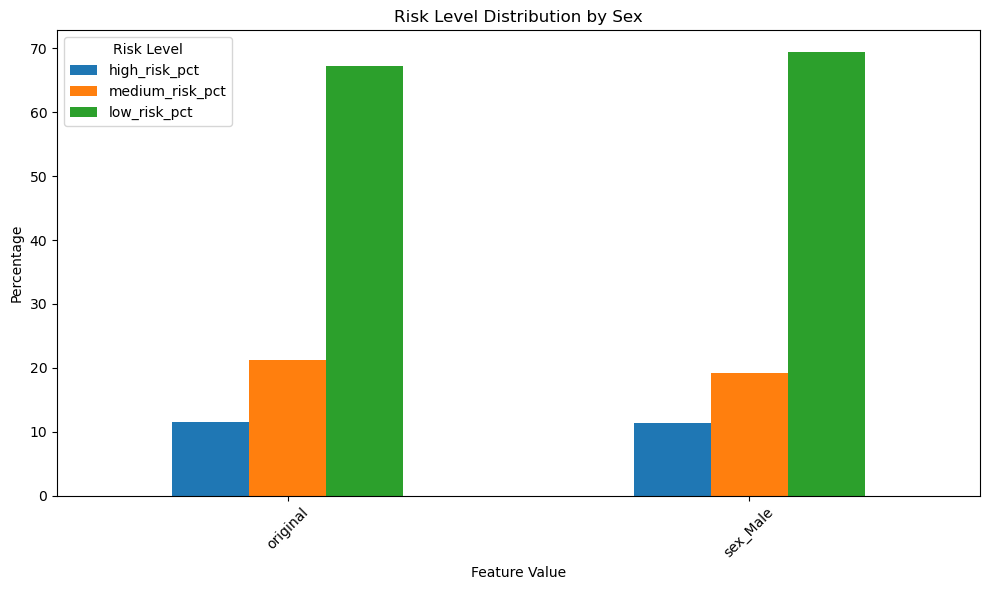

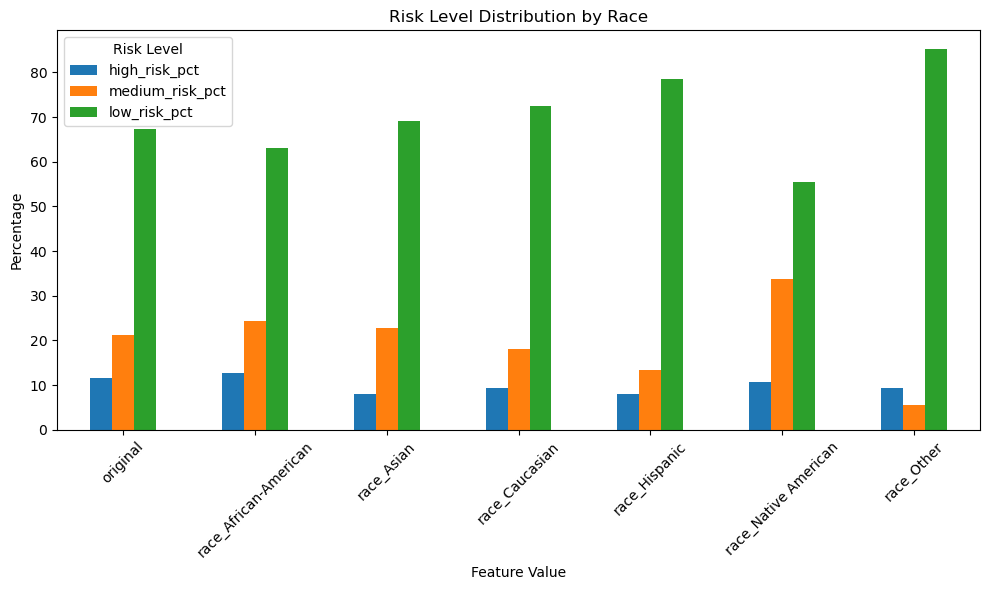

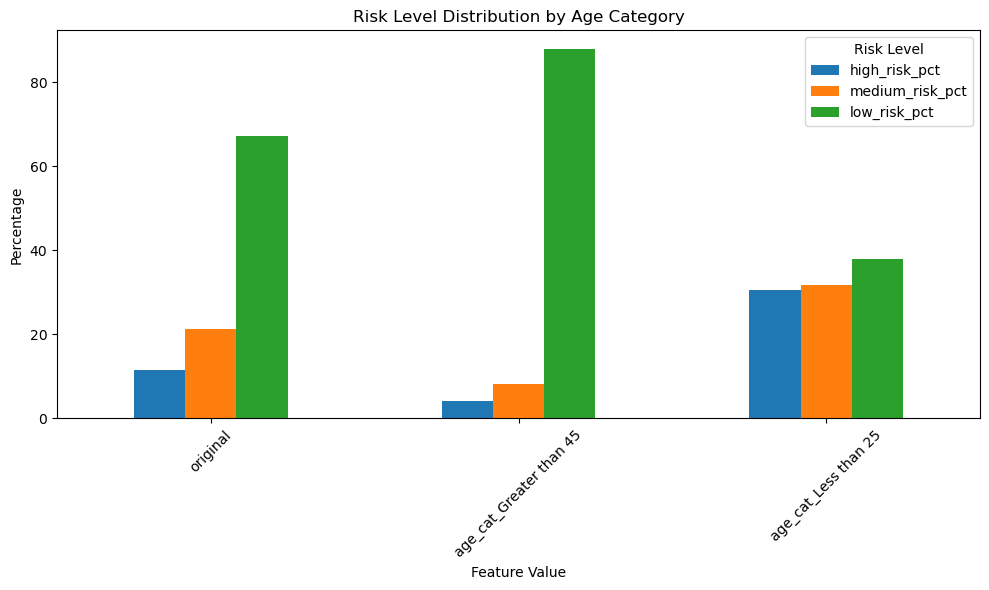

In [21]:

# Function to analyze bias using the best model
def analyze_feature_bias(model, X_test, feature_name, feature_values, other_features, label_encoder):
    results = []
    original_preds_encoded = model.predict(X_test)
    original_preds = label_encoder.inverse_transform(original_preds_encoded)
    
    # Store original predictions distribution
    results.append({
        'modification': 'original',
        'high_risk_pct': (original_preds == 'High').mean() * 100,
        'medium_risk_pct': (original_preds == 'Medium').mean() * 100,
        'low_risk_pct': (original_preds == 'Low').mean() * 100
    })
    
    # For each possible value
    for value in feature_values:
        X_modified = X_test.copy()
        for feat in other_features:
            X_modified[feat] = 0
        X_modified[value] = 1
        
        modified_preds_encoded = model.predict(X_modified)
        modified_preds = label_encoder.inverse_transform(modified_preds_encoded)
        
        results.append({
            'modification': value,
            'high_risk_pct': (modified_preds == 'High').mean() * 100,
            'medium_risk_pct': (modified_preds == 'Medium').mean() * 100,
            'low_risk_pct': (modified_preds == 'Low').mean() * 100
        })
    
    return pd.DataFrame(results)

# Analyze bias for different protected attributes
print("\nAnalyzing bias in predictions...")

# Sex bias analysis
sex_features = ['sex_Male']
sex_results = analyze_feature_bias(
    best_model, X_test, 'sex', sex_features, [], le
)
print("\nSex Bias Analysis:")
print(sex_results)

# Race bias analysis
race_features = [col for col in X_test.columns if col.startswith('race_')]
race_results = analyze_feature_bias(
    best_model, X_test, 'race', race_features, race_features, le
)
print("\nRace Bias Analysis:")
print(race_results)

# Age bias analysis
age_features = ['age_cat_Greater than 45', 'age_cat_Less than 25']
age_results = analyze_feature_bias(
    best_model, X_test, 'age_cat', age_features, age_features, le
)
print("\nAge Bias Analysis:")
print(age_results)

# Plot the results
def plot_bias_comparison(df, title):
    df.set_index('modification').plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('Percentage')
    plt.legend(title='Risk Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("\nVisualizing bias analysis results:")
plot_bias_comparison(sex_results, 'Risk Level Distribution by Sex')
plot_bias_comparison(race_results, 'Risk Level Distribution by Race')
plot_bias_comparison(age_results, 'Risk Level Distribution by Age Category')


Sex Bias Analysis:
  modification  high_risk_pct  medium_risk_pct  low_risk_pct
0     original      12.840647        18.752887     68.406467
1     sex_Male      12.193995        15.519630     72.286374


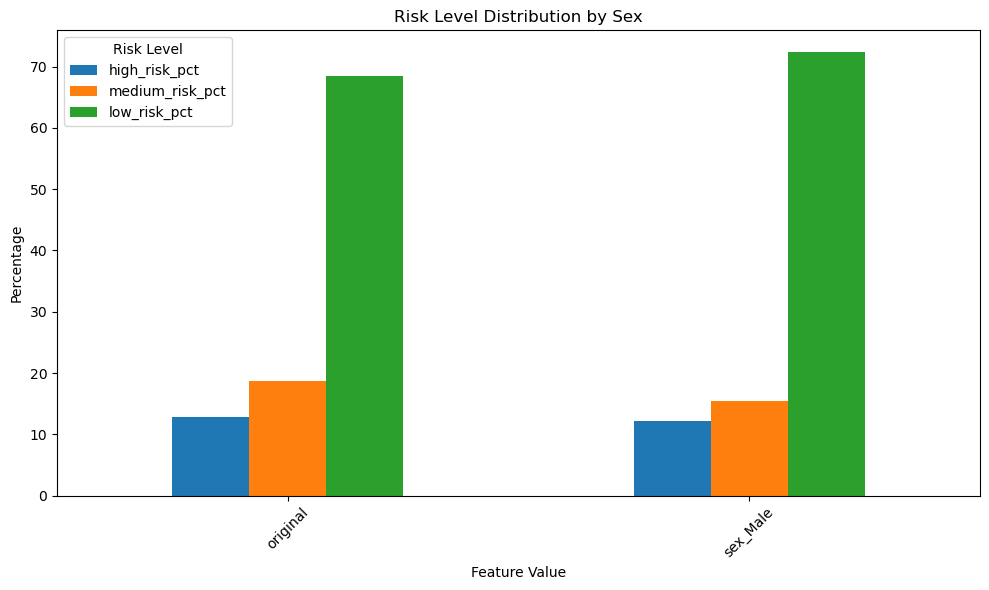


Age Bias Analysis:
              modification  high_risk_pct  medium_risk_pct  low_risk_pct
0                 original      12.840647        18.752887     68.406467
1  age_cat_Greater than 45       7.575058         8.129330     84.295612
2     age_cat_Less than 25      25.681293        34.595843     39.722864


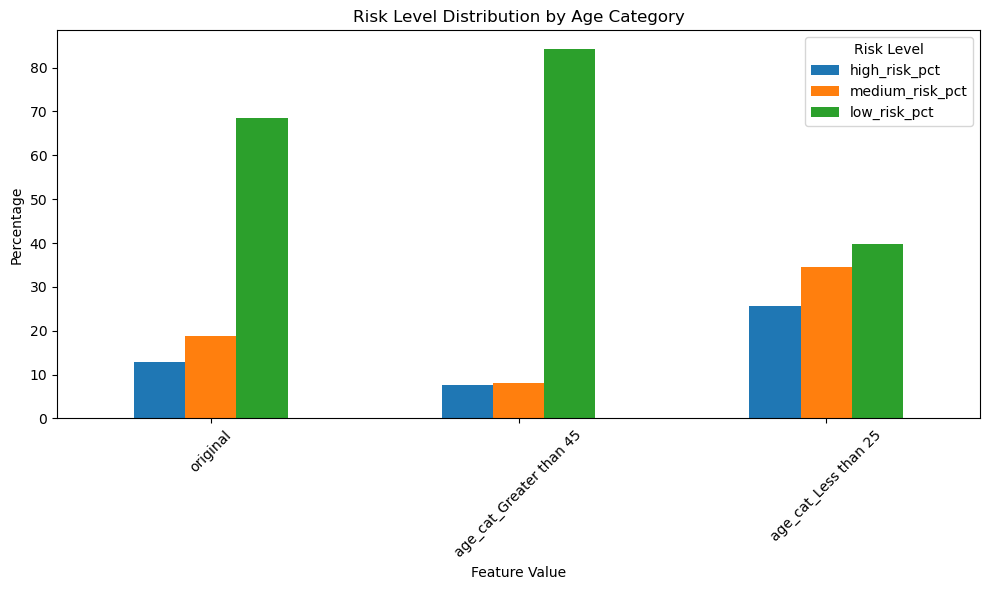


Race Bias Analysis:
            modification  high_risk_pct  medium_risk_pct  low_risk_pct
0               original      12.840647        18.752887     68.406467
1  race_African-American      13.533487        20.138568     66.327945
2             race_Asian       8.683603        15.796767     75.519630
3         race_Caucasian      10.254042        17.690531     72.055427
4          race_Hispanic       8.360277        17.367206     74.272517
5   race_Native American      16.443418        19.399538     64.157044
6             race_Other       9.745958        10.392610     79.861432


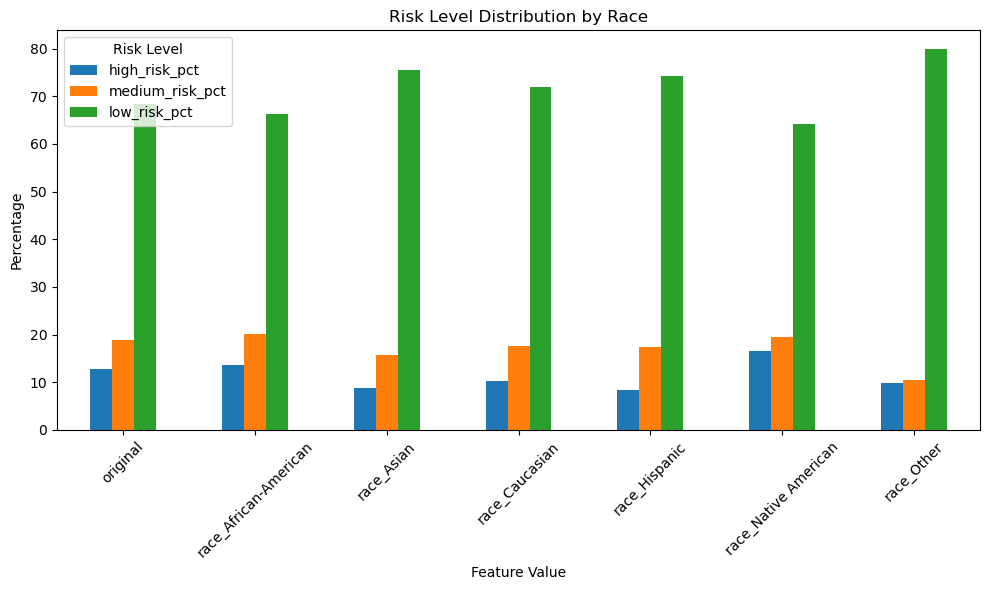


Analysis for Violence Score Model:

Sex Bias Analysis (Violence Score):
  modification  high_risk_pct  medium_risk_pct  low_risk_pct
0     original       5.127021        22.355658     72.517321
1     sex_Male       4.896074        22.863741     72.240185


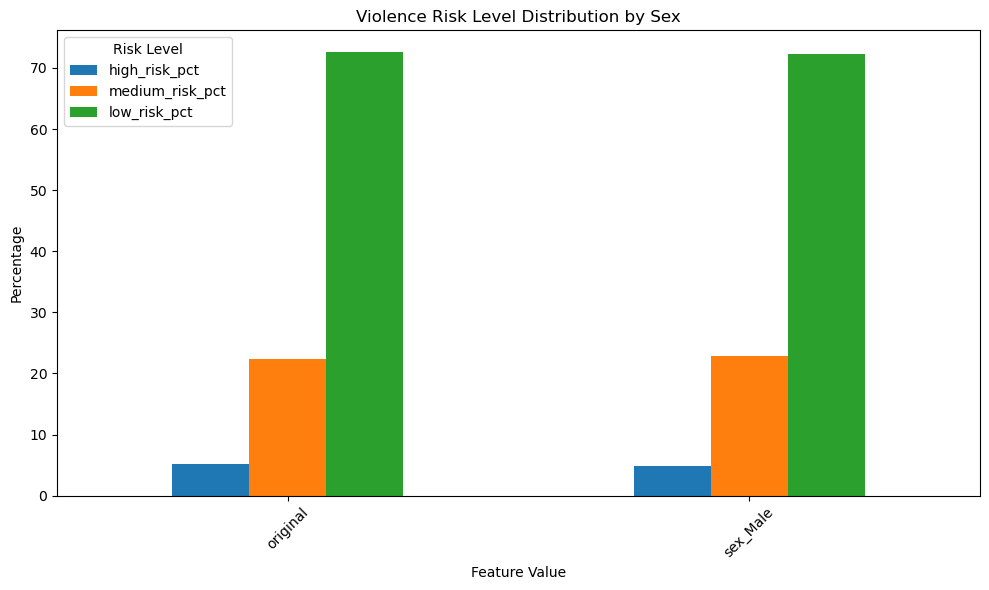

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def analyze_feature_bias(model, X_test, y_test, feature_name, feature_values, other_features):
    """
    Analyze prediction changes when modifying a single feature while keeping others constant.
    
    Args:
        model: Trained classifier model
        X_test: Test features DataFrame
        y_test: True test labels
        feature_name: Name of feature to analyze (e.g., 'sex_Male')
        feature_values: Possible values for the feature
        other_features: List of other related features to zero out
    
    Returns:
        DataFrame with comparison statistics
    """
    results = []
    original_preds = model.predict(X_test)
    
    # Store original predictions distribution
    results.append({
        'modification': 'original',
        'high_risk_pct': (original_preds == 'High').mean() * 100,
        'medium_risk_pct': (original_preds == 'Medium').mean() * 100,
        'low_risk_pct': (original_preds == 'Low').mean() * 100
    })
    
    # For each possible value
    for value in feature_values:
        # Create copy of test data
        X_modified = X_test.copy()
        
        # Zero out all related features
        for feat in other_features:
            X_modified[feat] = 0
            
        # Set the chosen feature value to 1
        X_modified[value] = 1
        
        # Get predictions
        modified_preds = model.predict(X_modified)
        
        # Calculate statistics
        results.append({
            'modification': value,
            'high_risk_pct': (modified_preds == 'High').mean() * 100,
            'medium_risk_pct': (modified_preds == 'Medium').mean() * 100,
            'low_risk_pct': (modified_preds == 'Low').mean() * 100
        })
    
    return pd.DataFrame(results)

def plot_bias_comparison(df, title):
    """
    Plot the comparison of risk levels across different feature values.
    """
    df.set_index('modification').plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('Percentage')
    plt.legend(title='Risk Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analysis for Sex
sex_features = ['sex_Male']
sex_results = analyze_feature_bias(
    clf_decile, X_test, y_test_decile,
    'sex', sex_features, []
)
print("\nSex Bias Analysis:")
print(sex_results)
plot_bias_comparison(sex_results, 'Risk Level Distribution by Sex')

# Analysis for Age
age_features = ['age_cat_Greater than 45', 'age_cat_Less than 25']
age_results = analyze_feature_bias(
    clf_decile, X_test, y_test_decile,
    'age_cat', age_features, age_features
)
print("\nAge Bias Analysis:")
print(age_results)
plot_bias_comparison(age_results, 'Risk Level Distribution by Age Category')

# Analysis for Race
race_features = [col for col in X_test.columns if col.startswith('race_')]
race_results = analyze_feature_bias(
    clf_decile, X_test, y_test_decile,
    'race', race_features, race_features
)
print("\nRace Bias Analysis:")
print(race_results)
plot_bias_comparison(race_results, 'Risk Level Distribution by Race')

# Repeat the same analysis for the violence score model
print("\nAnalysis for Violence Score Model:")
sex_results_v = analyze_feature_bias(
    clf_v_decile, X_test, y_test_v_decile,
    'sex', sex_features, []
)
print("\nSex Bias Analysis (Violence Score):")
print(sex_results_v)
plot_bias_comparison(sex_results_v, 'Violence Risk Level Distribution by Sex')

# Continue with age and race analysis for violence score...


Distribution for sex_Male:

Training Set Distribution (%):
score_text   High    Low  Medium
sex_Male                        
0           14.73  57.01   28.26
1           20.49  53.12   26.39

Test Set Distribution (%):
score_text   High    Low  Medium
sex_Male                        
0           10.83  59.19   29.97
1           21.66  53.22   25.11


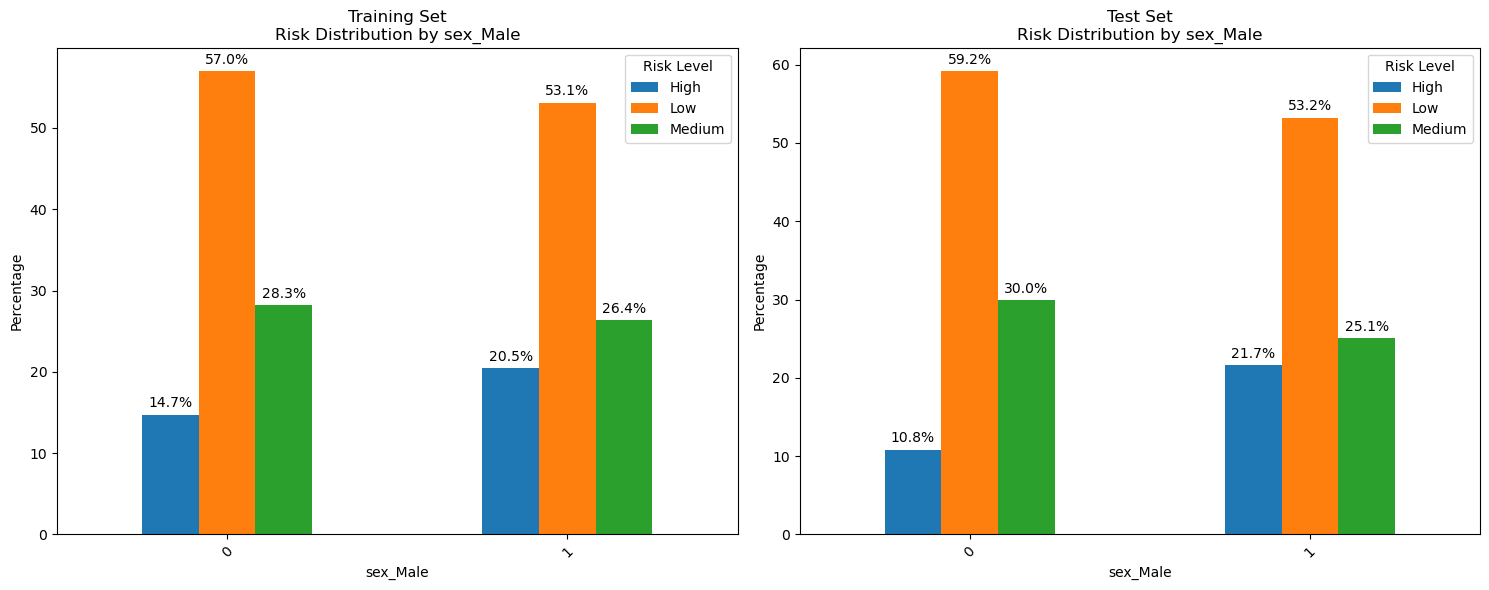


Distribution for age_cat_Greater than 45:

Training Set Distribution (%):
score_text                High   Low  Medium
age_cat_Greater than 45                     
0                        22.37  48.1   29.52
1                         8.75  74.2   17.05

Test Set Distribution (%):
score_text                High    Low  Medium
age_cat_Greater than 45                      
0                        23.17  48.27   28.55
1                         6.58  76.97   16.45


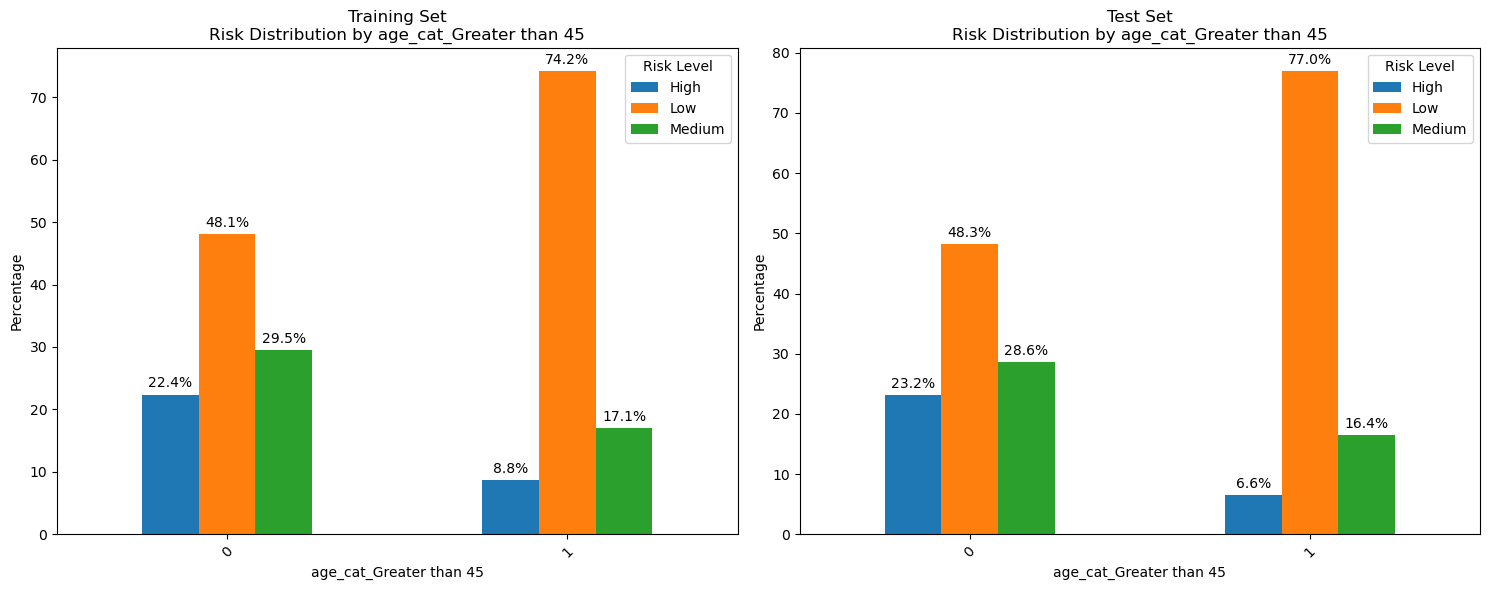


Distribution for age_cat_Less than 25:

Training Set Distribution (%):
score_text             High    Low  Medium
age_cat_Less than 25                      
0                     16.75  58.84   24.40
1                     29.10  35.31   35.59

Test Set Distribution (%):
score_text             High    Low  Medium
age_cat_Less than 25                      
0                     16.61  60.13   23.26
1                     30.84  33.19   35.97


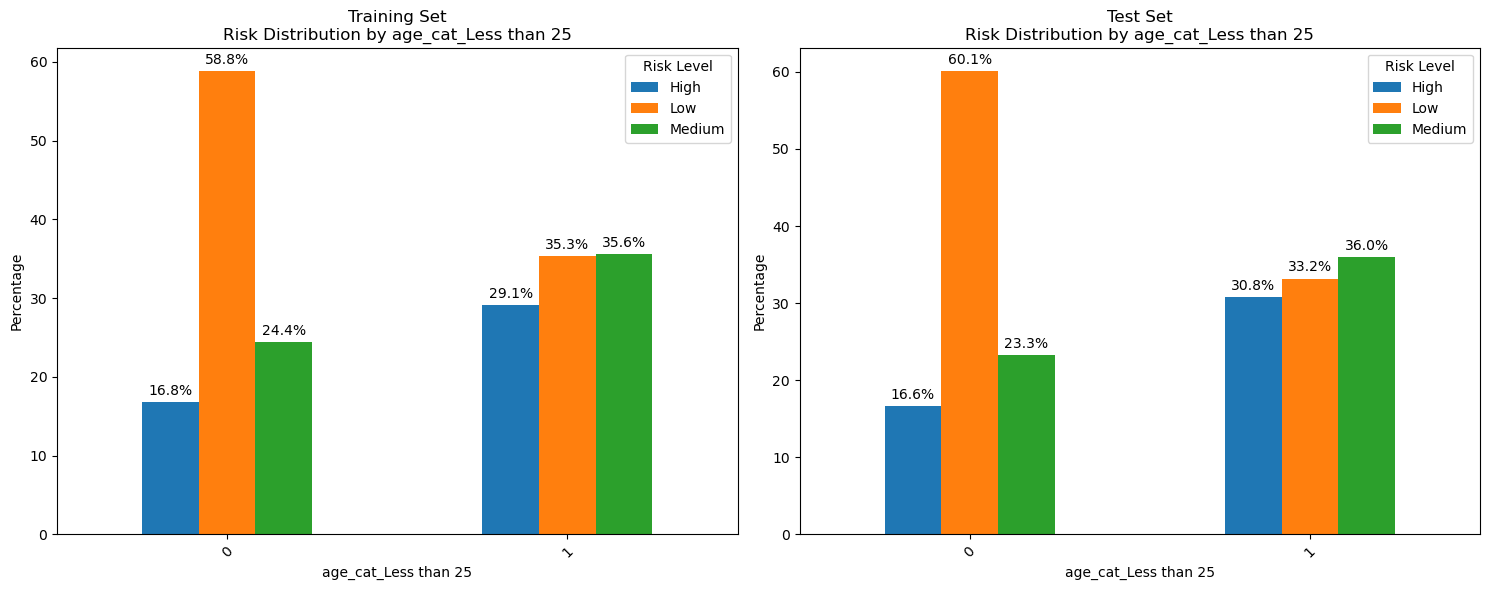


Distribution for race_African-American:

Training Set Distribution (%):
score_text              High    Low  Medium
race_African-American                      
0                      10.75  67.46   21.78
1                      27.55  40.94   31.50

Test Set Distribution (%):
score_text              High    Low  Medium
race_African-American                      
0                      10.73  67.62   21.65
1                      28.15  41.73   30.13


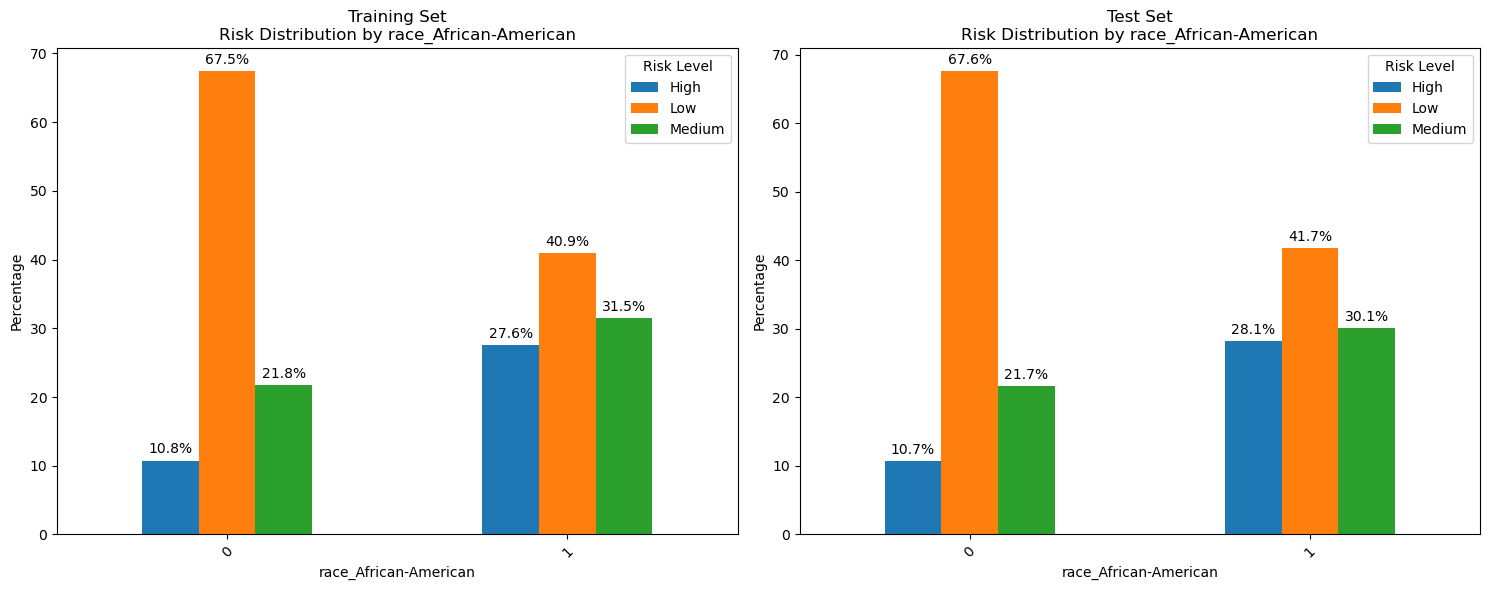


Distribution for race_Asian:

Training Set Distribution (%):
score_text   High    Low  Medium
race_Asian                      
0           19.41  53.79   26.80
1            7.69  73.08   19.23

Test Set Distribution (%):
score_text   High    Low  Medium
race_Asian                      
0           19.69  54.24   26.08
1           16.67  83.33    0.00


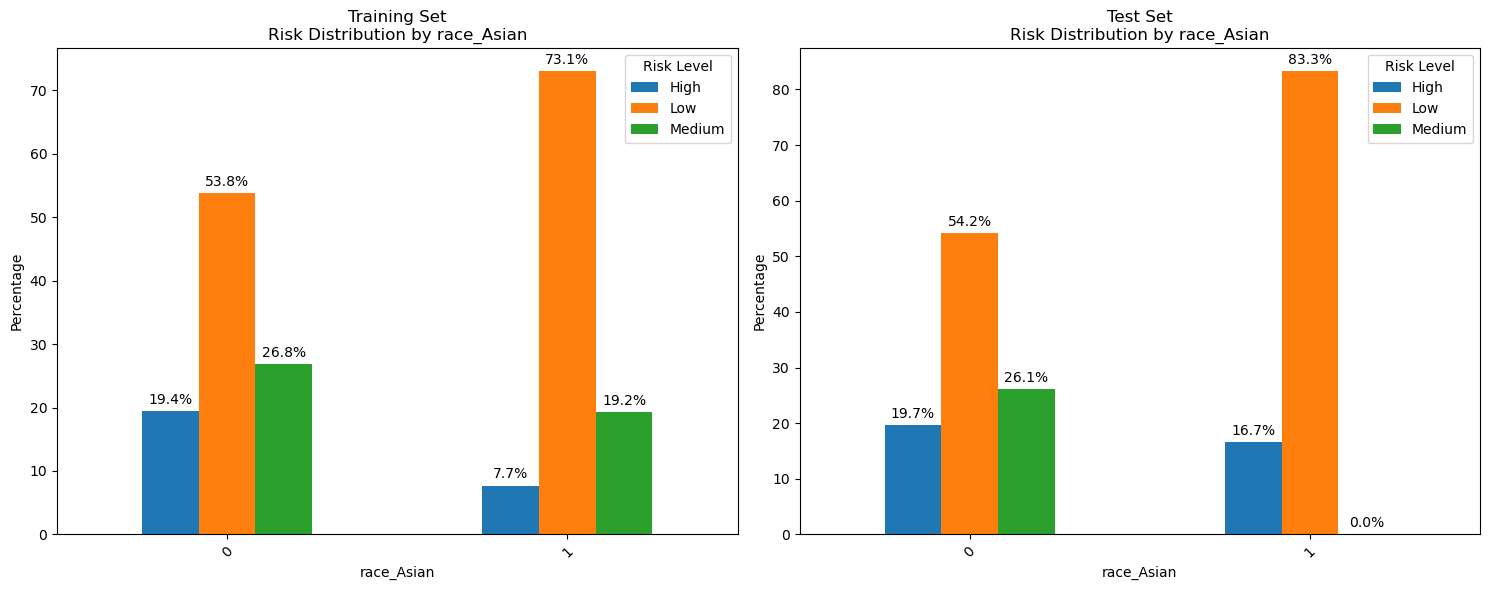


Distribution for race_Caucasian:

Training Set Distribution (%):
score_text       High    Low  Medium
race_Caucasian                      
0               23.57  47.98   28.46
1               11.14  65.40   23.45

Test Set Distribution (%):
score_text       High    Low  Medium
race_Caucasian                      
0               23.93  48.91   27.16
1               11.49  64.73   23.78


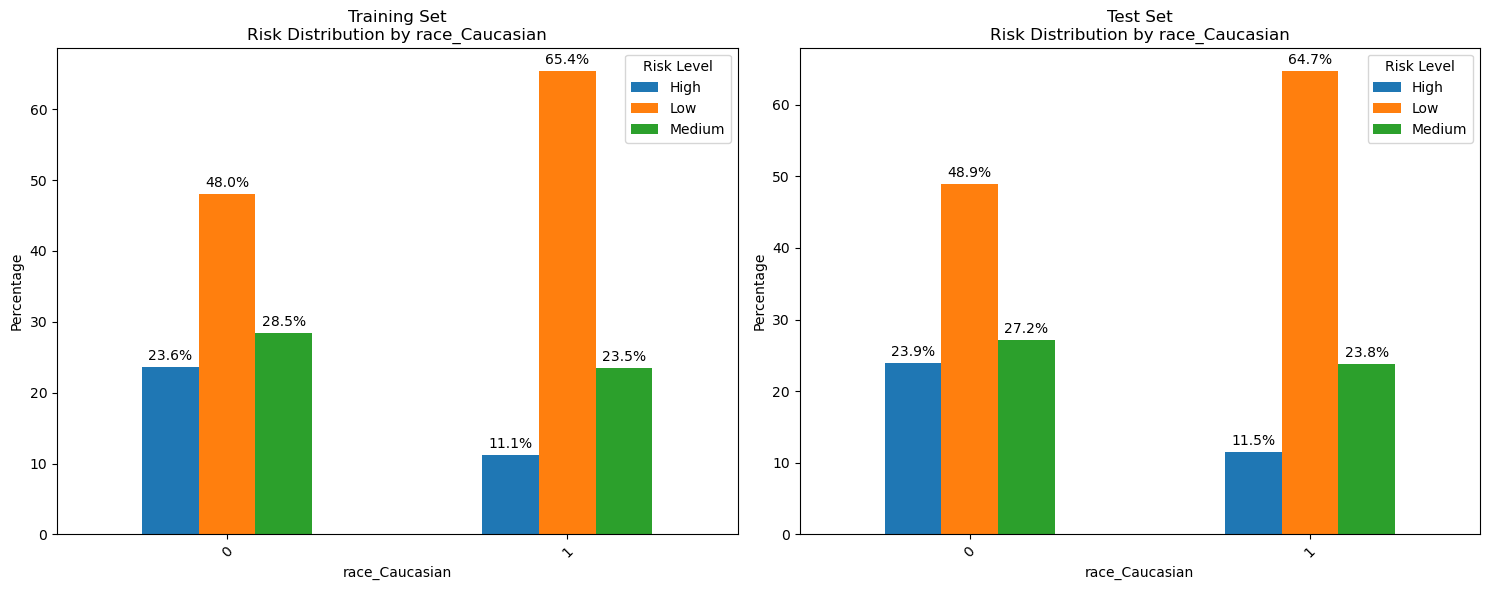


Distribution for race_Hispanic:

Training Set Distribution (%):
score_text      High    Low  Medium
race_Hispanic                      
0              20.24  52.36   27.40
1              10.35  69.38   20.26

Test Set Distribution (%):
score_text      High    Low  Medium
race_Hispanic                      
0              20.48  52.67   26.84
1              10.93  72.13   16.94


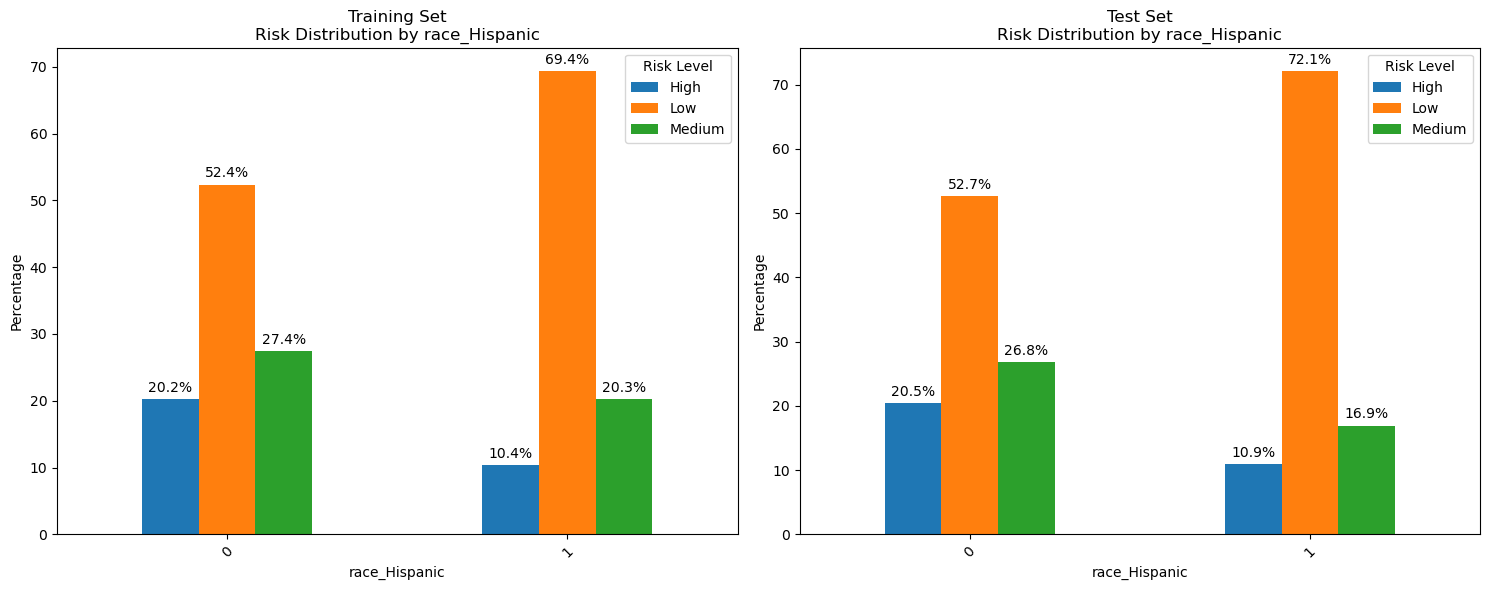


Distribution for race_Native American:

Training Set Distribution (%):
score_text             High    Low  Medium
race_Native American                      
0                     19.31  53.95   26.74
1                     33.33  33.33   33.33

Test Set Distribution (%):
score_text             High    Low  Medium
race_Native American                      
0                     19.66  54.35   25.99
1                     33.33  33.33   33.33


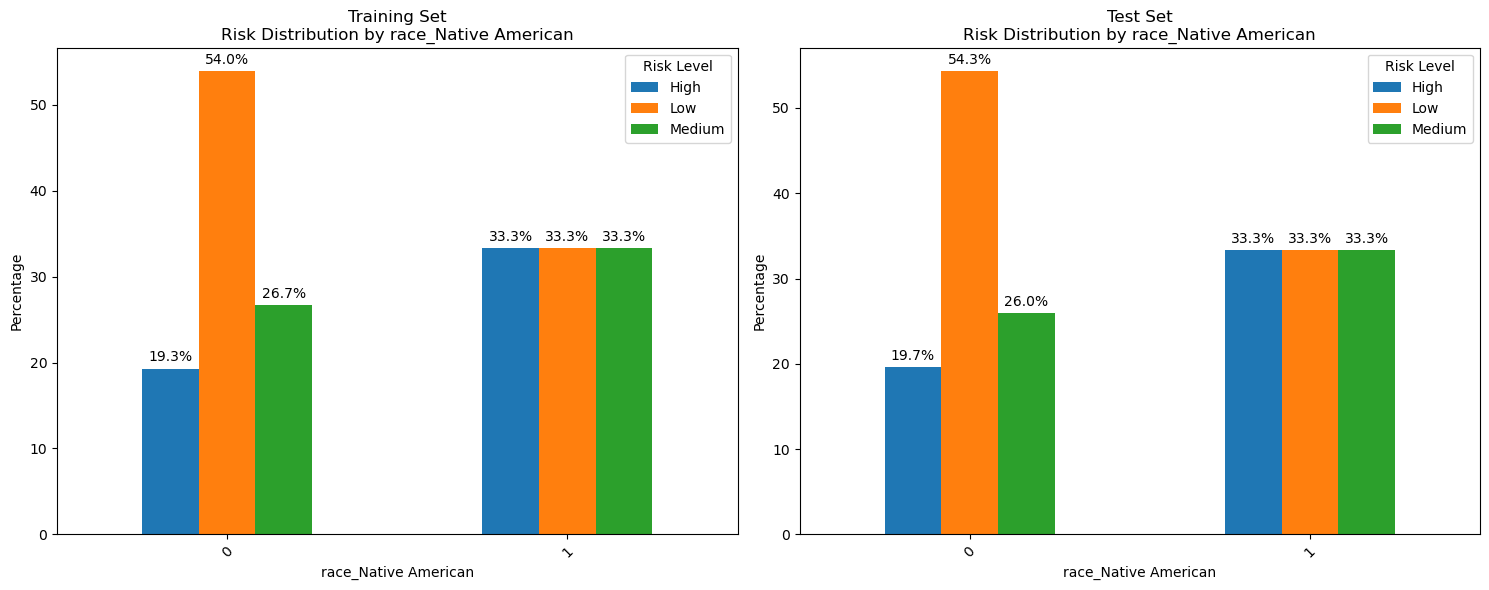


Distribution for race_Other:

Training Set Distribution (%):
score_text   High    Low  Medium
race_Other                      
0           19.97  52.53   27.50
1            7.81  79.30   12.89

Test Set Distribution (%):
score_text   High    Low  Medium
race_Other                      
0           20.55  52.89   26.57
1            4.96  78.51   16.53


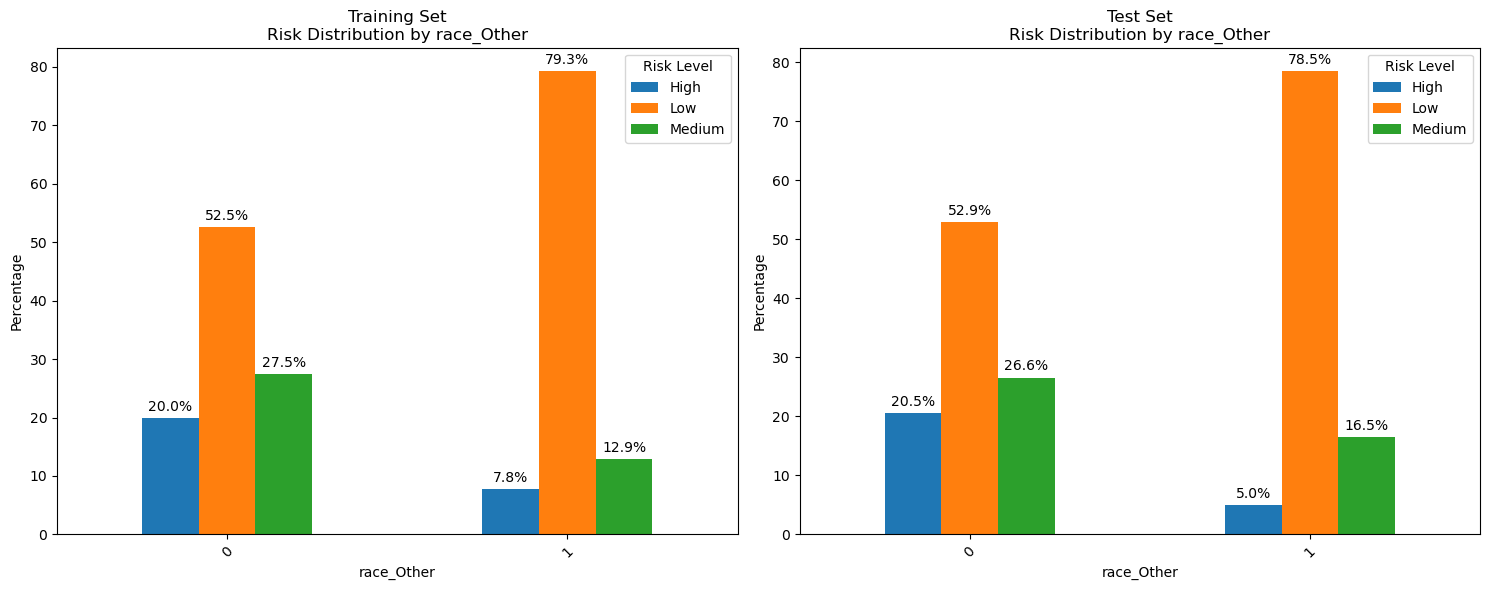


Overall Class Distribution:

Training Set Distribution (%):
Low       53.89
Medium    26.76
High      19.35
dtype: float64

Test Set Distribution (%):
Low       54.32
Medium    26.00
High      19.68
dtype: float64


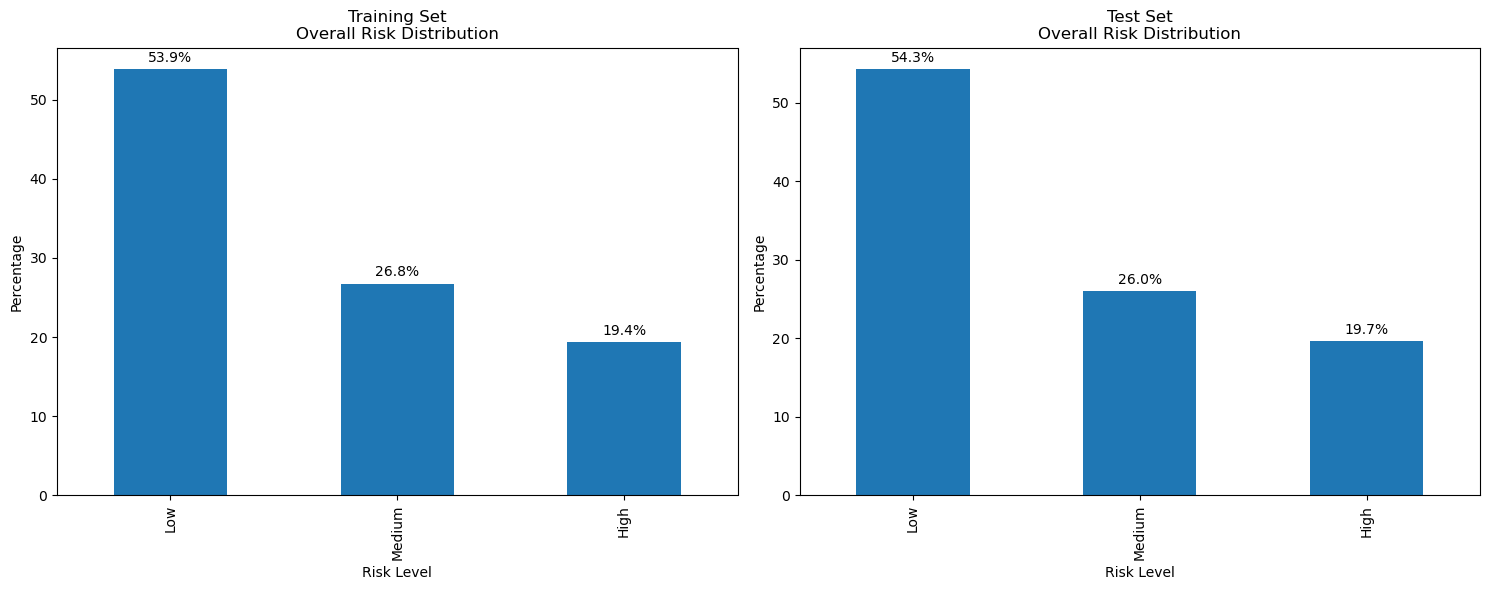

In [23]:
# Cell 1: Analyze distributions in training and test sets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_split_distributions(X, y, feature_column, test_size=0.3, random_state=42):
    """
    Analyze class distributions in both training and test sets for a given feature
    """
    # Combine features and target
    combined_data = pd.concat([X, y], axis=1)
    
    # Split the data
    train_data, test_data = train_test_split(combined_data, test_size=test_size, random_state=random_state)
    
    # Calculate distributions for both sets
    train_dist = pd.crosstab(train_data[feature_column], train_data['score_text'], 
                            normalize='index') * 100
    test_dist = pd.crosstab(test_data[feature_column], test_data['score_text'], 
                           normalize='index') * 100
    
    # Print exact distributions
    print(f"\nDistribution for {feature_column}:")
    print("\nTraining Set Distribution (%):")
    print(train_dist.round(2))
    print("\nTest Set Distribution (%):")
    print(test_dist.round(2))
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set plot
    bars1 = train_dist.plot(kind='bar', ax=ax1)
    ax1.set_title(f'Training Set\nRisk Distribution by {feature_column}')
    ax1.set_xlabel(feature_column)
    ax1.set_ylabel('Percentage')
    ax1.legend(title='Risk Level')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add percentage labels for training set
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f%%', padding=3)
    
    # Test set plot
    bars2 = test_dist.plot(kind='bar', ax=ax2)
    ax2.set_title(f'Test Set\nRisk Distribution by {feature_column}')
    ax2.set_xlabel(feature_column)
    ax2.set_ylabel('Percentage')
    ax2.legend(title='Risk Level')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add percentage labels for test set
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', padding=3)
    
    plt.tight_layout()
    plt.show()

# Combine features and target
full_data = pd.concat([X, class_y], axis=1)

# Analyze sex distribution
analyze_split_distributions(X, class_y, 'sex_Male')

# Analyze age distribution
for age_feat in ['age_cat_Greater than 45', 'age_cat_Less than 25']:
    analyze_split_distributions(X, class_y, age_feat)

# Analyze race distribution
race_features = [col for col in X.columns if col.startswith('race_')]
for race_feat in race_features:
    analyze_split_distributions(X, class_y, race_feat)

# Also show overall class distribution
def plot_overall_distribution():
    # Calculate overall distributions
    train_overall = pd.Series(y_train_decile).map(lambda x: le.inverse_transform([x])[0]).value_counts(normalize=True) * 100
    test_overall = pd.Series(y_test_decile).map(lambda x: le.inverse_transform([x])[0]).value_counts(normalize=True) * 100
    
    print("\nOverall Class Distribution:")
    print("\nTraining Set Distribution (%):")
    print(train_overall.round(2))
    print("\nTest Set Distribution (%):")
    print(test_overall.round(2))
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Training set
    bars1 = train_overall.plot(kind='bar', ax=ax1)
    ax1.set_title('Training Set\nOverall Risk Distribution')
    ax1.set_ylabel('Percentage')
    ax1.set_xlabel('Risk Level')
    
    # Add percentage labels
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f%%', padding=3)
    
    # Test set
    bars2 = test_overall.plot(kind='bar', ax=ax2)
    ax2.set_title('Test Set\nOverall Risk Distribution')
    ax2.set_ylabel('Percentage')
    ax2.set_xlabel('Risk Level')
    
    # Add percentage labels
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.1f%%', padding=3)
    
    plt.tight_layout()
    plt.show()

# Plot overall distribution
plot_overall_distribution()

In [24]:
# Cell 2: Analyze modifications using the trained model
def analyze_feature_modifications(model, X_test, feature_name, feature_values, other_features, label_encoder):
    results = []
    original_preds_encoded = model.predict(X_test)
    original_preds = label_encoder.inverse_transform(original_preds_encoded)
    
    # Calculate and store original predictions distribution
    orig_dist = {
        'modification': 'Original',
        'High': (original_preds == 'High').mean() * 100,
        'Medium': (original_preds == 'Medium').mean() * 100,
        'Low': (original_preds == 'Low').mean() * 100
    }
    results.append(orig_dist)
    
    # For each feature value
    for value in feature_values:
        X_modified = X_test.copy()
        
        # Zero out related features
        for feat in other_features:
            X_modified[feat] = 0
        
        # Set the current feature value
        X_modified[value] = 1
        
        # Get predictions
        modified_preds_encoded = model.predict(X_modified)
        modified_preds = label_encoder.inverse_transform(modified_preds_encoded)
        
        # Calculate distribution
        mod_dist = {
            'modification': value,
            'High': (modified_preds == 'High').mean() * 100,
            'Medium': (modified_preds == 'Medium').mean() * 100,
            'Low': (modified_preds == 'Low').mean() * 100
        }
        results.append(mod_dist)
    
    return pd.DataFrame(results)

def plot_modification_results(df, title):
    # Set up the plot
    plt.figure(figsize=(12, 6))
    
    # Create the grouped bar plot
    x = range(len(df['modification']))
    width = 0.25
    
    plt.bar(x, df['High'], width, label='High', color='red', alpha=0.7)
    plt.bar([i + width for i in x], df['Medium'], width, label='Medium', color='yellow', alpha=0.7)
    plt.bar([i + width*2 for i in x], df['Low'], width, label='Low', color='green', alpha=0.7)
    
    # Customize the plot
    plt.xlabel('Modification')
    plt.ylabel('Percentage')
    plt.title(title)
    plt.xticks([i + width for i in x], df['modification'], rotation=45)
    plt.legend()
    
    # Add percentage labels
    for i in x:
        plt.text(i, df['High'].iloc[i]/2, f'{df["High"].iloc[i]:.1f}%', ha='center', va='center')
        plt.text(i + width, df['Medium'].iloc[i]/2, f'{df["Medium"].iloc[i]:.1f}%', ha='center', va='center')
        plt.text(i + width*2, df['Low'].iloc[i]/2, f'{df["Low"].iloc[i]:.1f}%', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print exact percentages
    print("\nExact percentages:")
    print(df.round(2))

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

def create_counterfactual_predictions(model, X_test, protected_feature, label_encoder):
    """
    Create counterfactual predictions by modifying a protected feature while keeping
    other features constant.
    
    Args:
        model: Trained classifier model
        X_test: Test features DataFrame
        protected_feature: Name of the protected feature to modify (e.g., 'sex_Male')
        label_encoder: LabelEncoder used for target variable
    
    Returns:
        DataFrame with original and counterfactual predictions
    """
    results = []
    
    # Get original predictions
    original_preds_encoded = model.predict(X_test)
    original_preds = label_encoder.inverse_transform(original_preds_encoded)
    
    # Create modified version with protected feature flipped
    X_modified = X_test.copy()
    
    if protected_feature == 'sex_Male':
        X_modified['sex_Male'] = 1 - X_modified['sex_Male']
    
    elif protected_feature.startswith('age_cat'):
        age_features = ['age_cat_Greater than 45', 'age_cat_Less than 25']
        # Reset all age categories
        for feat in age_features:
            X_modified[feat] = 0
        # Set the target category
        X_modified[protected_feature] = 1
    
    elif protected_feature.startswith('race'):
        race_features = [col for col in X_test.columns if col.startswith('race_')]
        # Reset all race categories
        for feat in race_features:
            X_modified[feat] = 0
        # Set the target race
        X_modified[protected_feature] = 1
    
    # Get counterfactual predictions
    modified_preds_encoded = model.predict(X_modified)
    modified_preds = label_encoder.inverse_transform(modified_preds_encoded)
    
    # Combine results
    for i in range(len(X_test)):
        results.append({
            'Original_Prediction': original_preds[i],
            'Counterfactual_Prediction': modified_preds[i],
            'Changed': original_preds[i] != modified_preds[i]
        })
    
    return pd.DataFrame(results)

def analyze_prediction_changes(df):
    """
    Analyze how predictions change when modifying protected attributes.
    """
    total_samples = len(df)
    changed_samples = df['Changed'].sum()
    change_percentage = (changed_samples / total_samples) * 100
    
    # Create transition matrix
    transitions = pd.crosstab(df['Original_Prediction'], 
                            df['Counterfactual_Prediction'], 
                            normalize='index') * 100
    
    return {
        'total_samples': total_samples,
        'changed_samples': changed_samples,
        'change_percentage': change_percentage,
        'transitions': transitions
    }

def plot_transition_matrix(transitions, title):
    """
    Plot transition matrix as a heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(transitions, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title(f'Prediction Transitions: {title}\n(% of original predictions)')
    plt.xlabel('Counterfactual Prediction')
    plt.ylabel('Original Prediction')
    plt.tight_layout()
    plt.show()

# Additional visualization: Distribution of changes by original prediction
def plot_change_distribution(df, title):
    plt.figure(figsize=(12, 6))
    
    # Calculate percentage of changes for each original prediction
    change_dist = df.groupby('Original_Prediction')['Changed'].agg(['count', 'sum'])
    change_dist['percentage'] = (change_dist['sum'] / change_dist['count']) * 100
    
    # Plot
    ax = change_dist['percentage'].plot(kind='bar')
    plt.title(f'Percentage of Changed Predictions by Original Risk Level: {title}')
    plt.xlabel('Original Risk Level')
    plt.ylabel('Percentage of Changed Predictions')
    
    # Add value labels
    for i, v in enumerate(change_dist['percentage']):
        ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


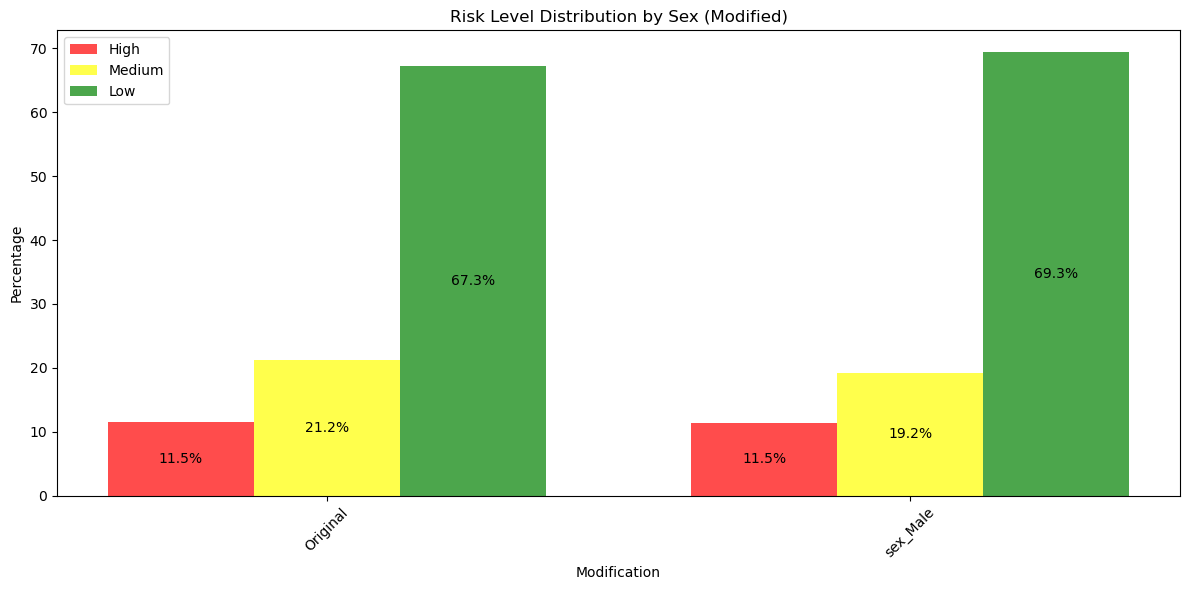


Exact percentages:
  modification   High  Medium    Low
0     Original  11.50   21.25  67.25
1     sex_Male  11.45   19.21  69.33

Analyzing counterfactual predictions for sex...

Sex changes summary:
Total samples: 2165
Changed predictions: 257 (11.9%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       92.771084   0.000000   7.228916
Low                         0.000000  88.873626  11.126374
Medium                      6.086957  10.652174  83.260870


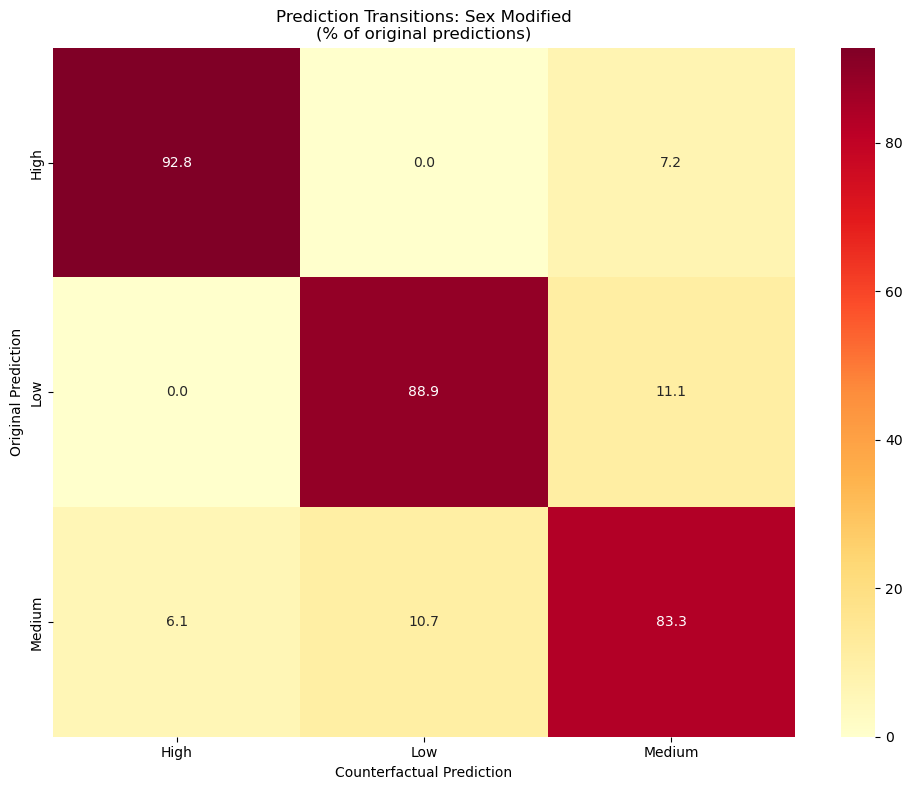


Visualizing distribution of changes...


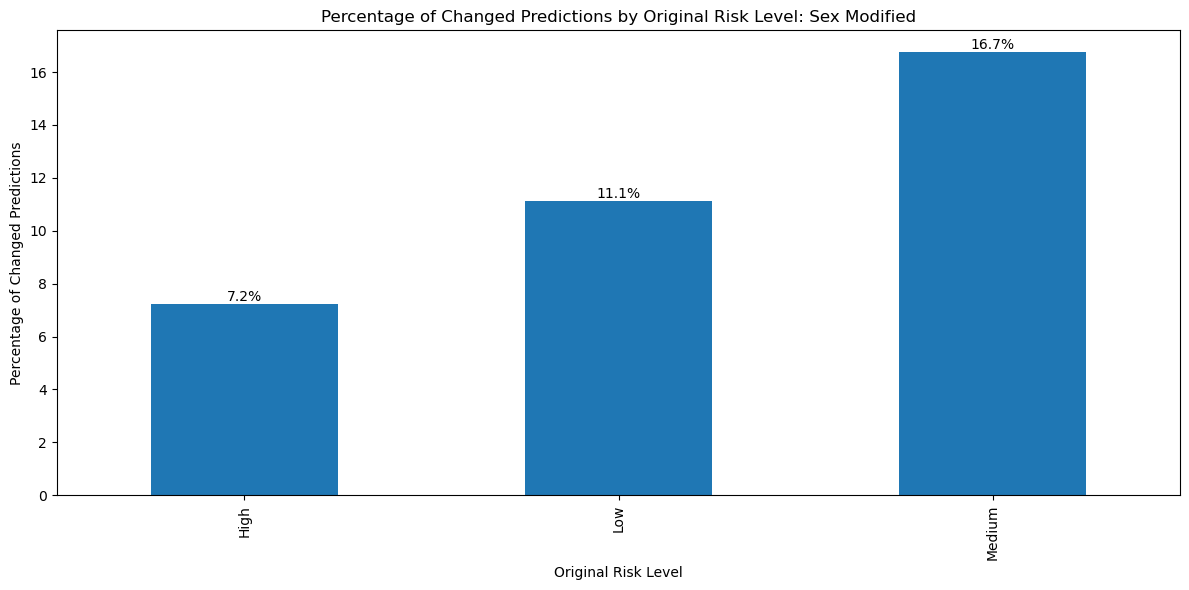

In [26]:
# Analyze transitions for sex

# Analyze sex modifications
sex_features = ['sex_Male']
sex_results = analyze_feature_modifications(
    best_model, X_test, 'sex', sex_features, [], le
)
plot_modification_results(sex_results, 'Risk Level Distribution by Sex (Modified)')

print("\nAnalyzing counterfactual predictions for sex...")
sex_changes = create_counterfactual_predictions(best_model, X_test, 'sex_Male', le)
sex_analysis = analyze_prediction_changes(sex_changes)
print(f"\nSex changes summary:")
print(f"Total samples: {sex_analysis['total_samples']}")
print(f"Changed predictions: {sex_analysis['changed_samples']} ({sex_analysis['change_percentage']:.1f}%)")
print("\nTransition matrix (%):")
print(sex_analysis['transitions'])
plot_transition_matrix(sex_analysis['transitions'], 'Sex Modified')

print("\nVisualizing distribution of changes...")
plot_change_distribution(sex_changes, 'Sex Modified')

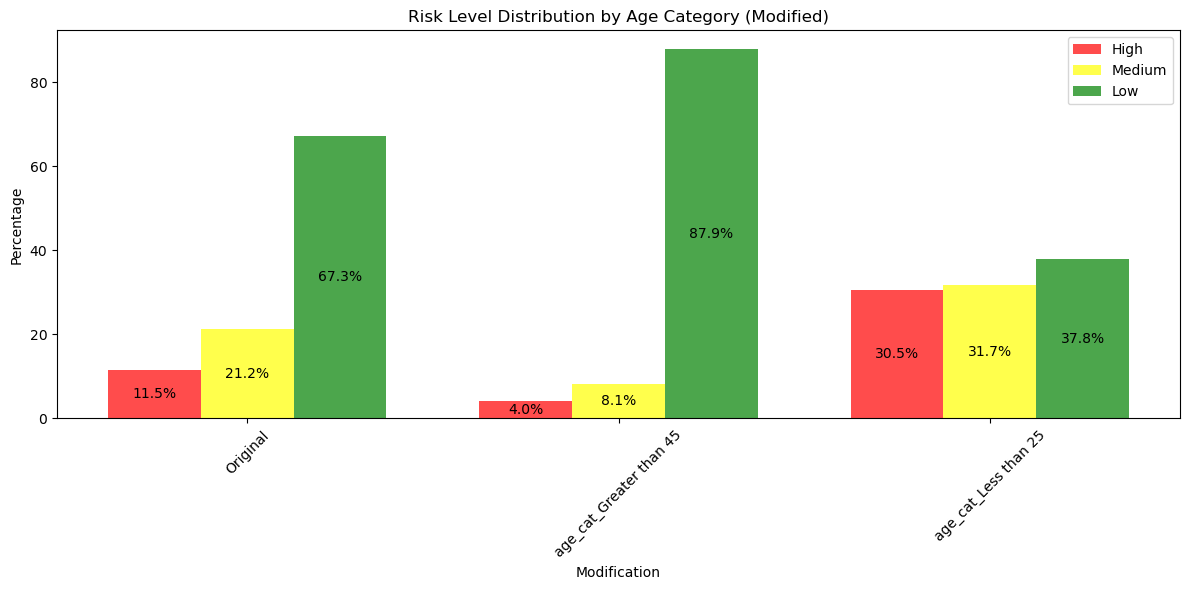


Exact percentages:
              modification   High  Medium    Low
0                 Original  11.50   21.25  67.25
1  age_cat_Greater than 45   4.02    8.08  87.90
2     age_cat_Less than 25  30.48   31.69  37.83

Analyzing counterfactual predictions for age_cat_Greater than 45...

age_cat_Greater than 45 changes summary:
Total samples: 2165
Changed predictions: 526 (24.3%)

Transition matrix (%):
Counterfactual_Prediction       High         Low     Medium
Original_Prediction                                        
High                       34.939759   33.333333  31.726908
Low                         0.000000  100.000000   0.000000
Medium                      0.000000   79.130435  20.869565


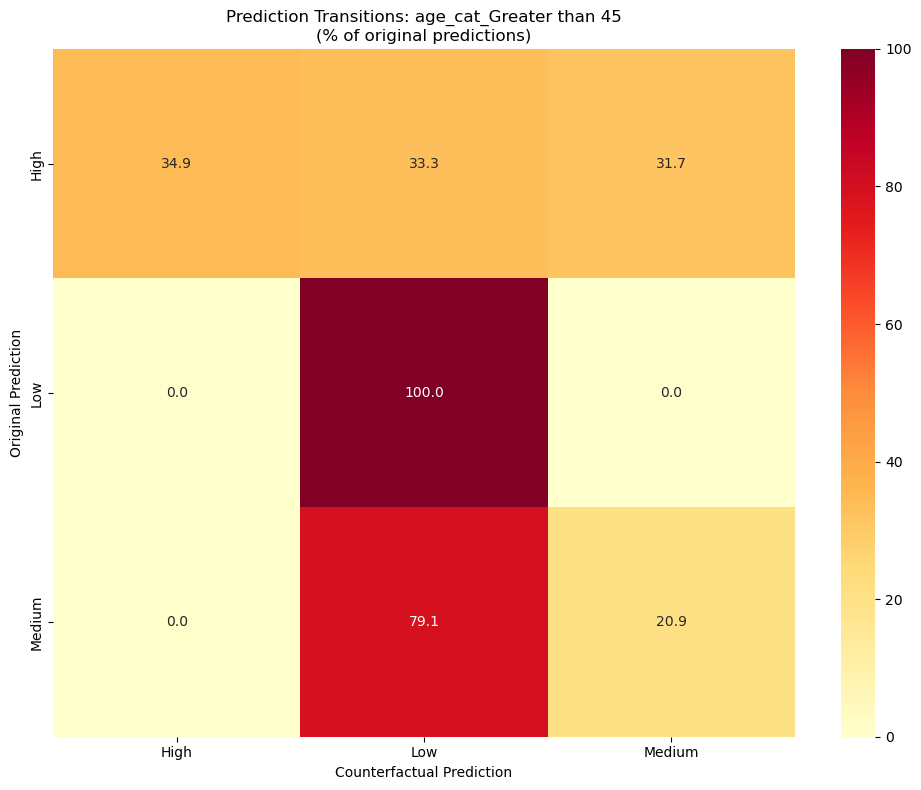


Analyzing counterfactual predictions for age_cat_Less than 25...

age_cat_Less than 25 changes summary:
Total samples: 2165
Changed predictions: 889 (41.1%)

Transition matrix (%):
Counterfactual_Prediction        High    Low     Medium
Original_Prediction                                    
High                       100.000000   0.00   0.000000
Low                         10.920330  56.25  32.829670
Medium                      54.782609   0.00  45.217391


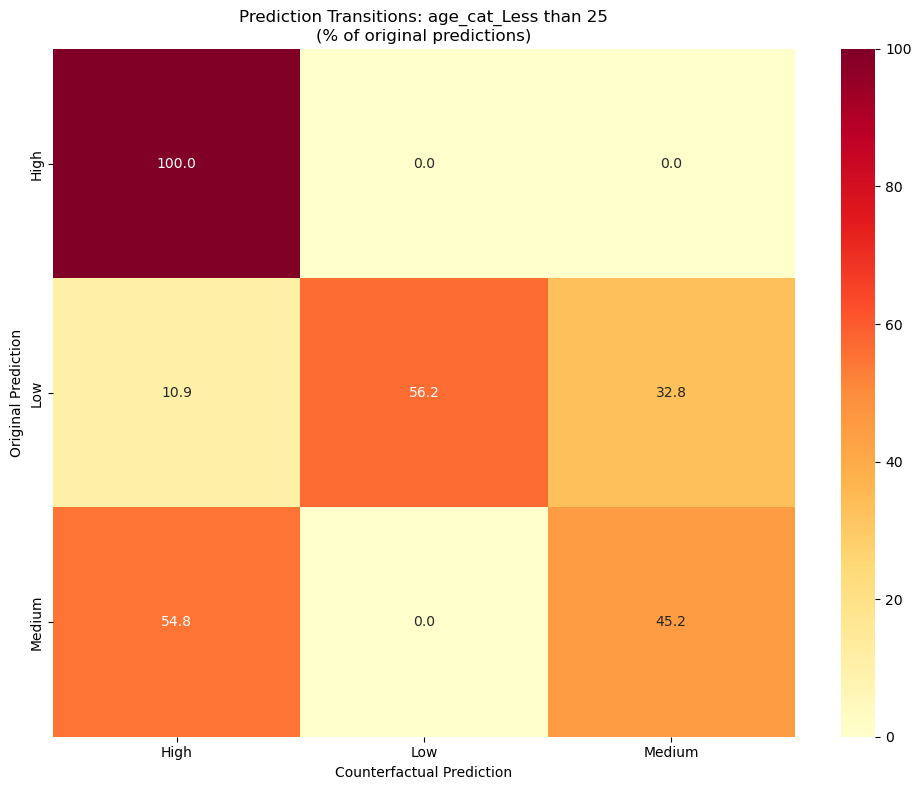


Visualizing distribution of changes...


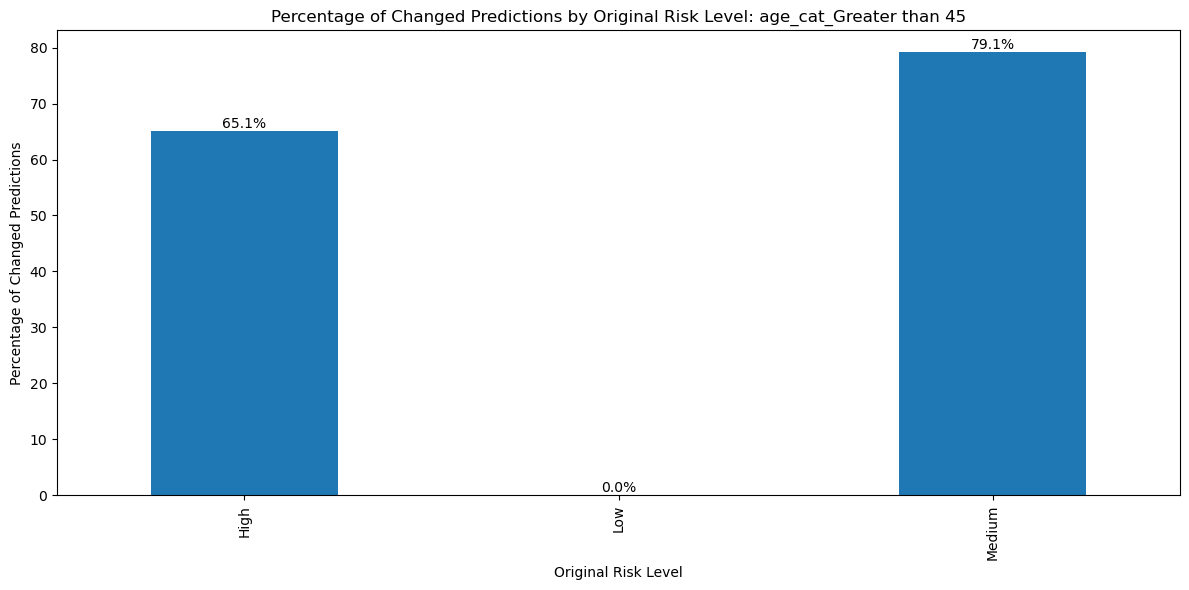

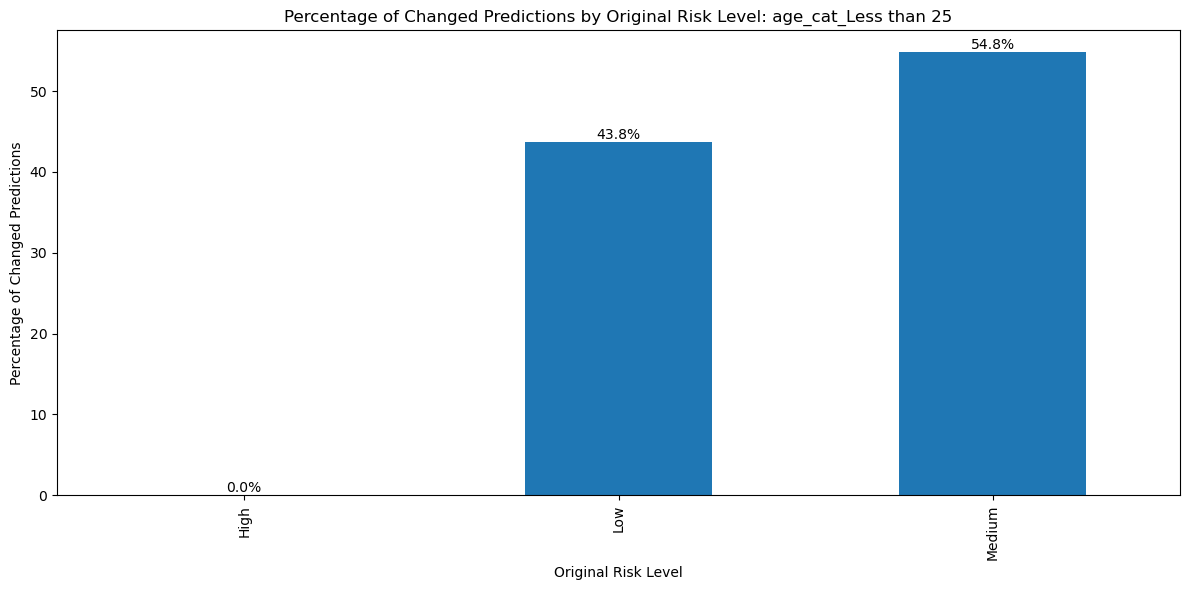

In [27]:
# Analyze transitions for age categories

age_features = ['age_cat_Greater than 45', 'age_cat_Less than 25']
age_results = analyze_feature_modifications(
    best_model, X_test, 'age_cat', age_features, age_features, le
)
plot_modification_results(age_results, 'Risk Level Distribution by Age Category (Modified)')

for age_cat in ['age_cat_Greater than 45', 'age_cat_Less than 25']:
    print(f"\nAnalyzing counterfactual predictions for {age_cat}...")
    age_changes = create_counterfactual_predictions(best_model, X_test, age_cat, le)
    age_analysis = analyze_prediction_changes(age_changes)
    print(f"\n{age_cat} changes summary:")
    print(f"Total samples: {age_analysis['total_samples']}")
    print(f"Changed predictions: {age_analysis['changed_samples']} ({age_analysis['change_percentage']:.1f}%)")
    print("\nTransition matrix (%):")
    print(age_analysis['transitions'])
    plot_transition_matrix(age_analysis['transitions'], age_cat)


print("\nVisualizing distribution of changes...")
for age_cat in ['age_cat_Greater than 45', 'age_cat_Less than 25']:
    age_changes = create_counterfactual_predictions(best_model, X_test, age_cat, le)
    plot_change_distribution(age_changes, age_cat)

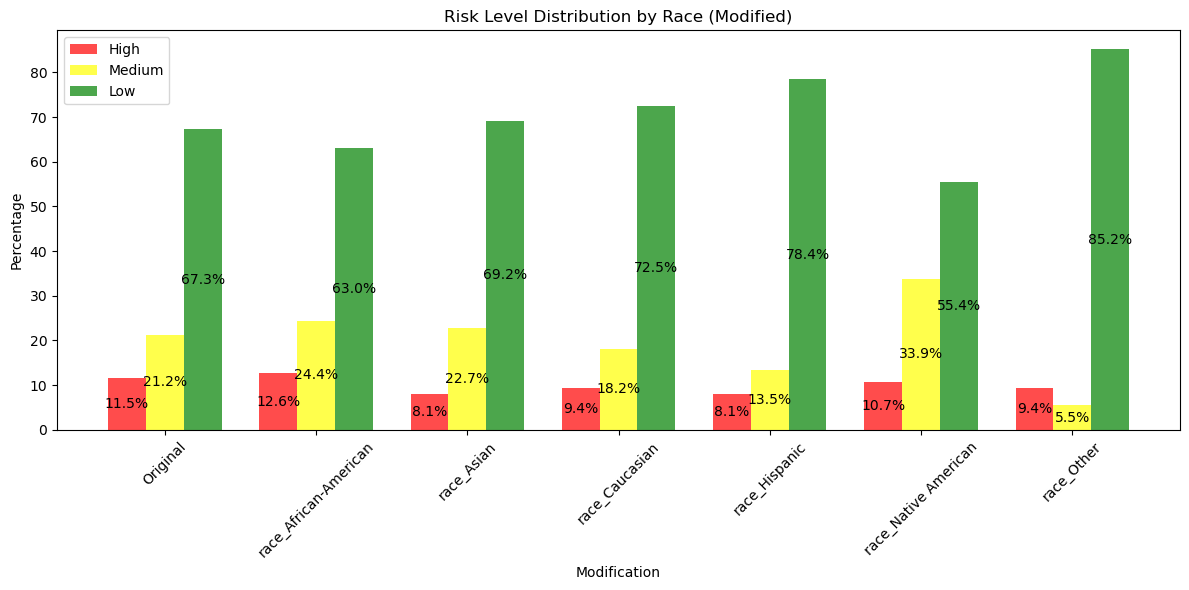


Exact percentages:
            modification   High  Medium    Low
0               Original  11.50   21.25  67.25
1  race_African-American  12.61   24.39  63.00
2             race_Asian   8.08   22.68  69.24
3         race_Caucasian   9.38   18.15  72.47
4          race_Hispanic   8.08   13.49  78.43
5   race_Native American  10.72   33.86  55.43
6             race_Other   9.38    5.45  85.17

Analyzing counterfactual predictions for race_African-American...

race_African-American changes summary:
Total samples: 2165
Changed predictions: 118 (5.5%)

Transition matrix (%):
Counterfactual_Prediction        High        Low     Medium
Original_Prediction                                        
High                       100.000000   0.000000   0.000000
Low                          0.137363  93.543956   6.318681
Medium                       4.782609   0.434783  94.782609


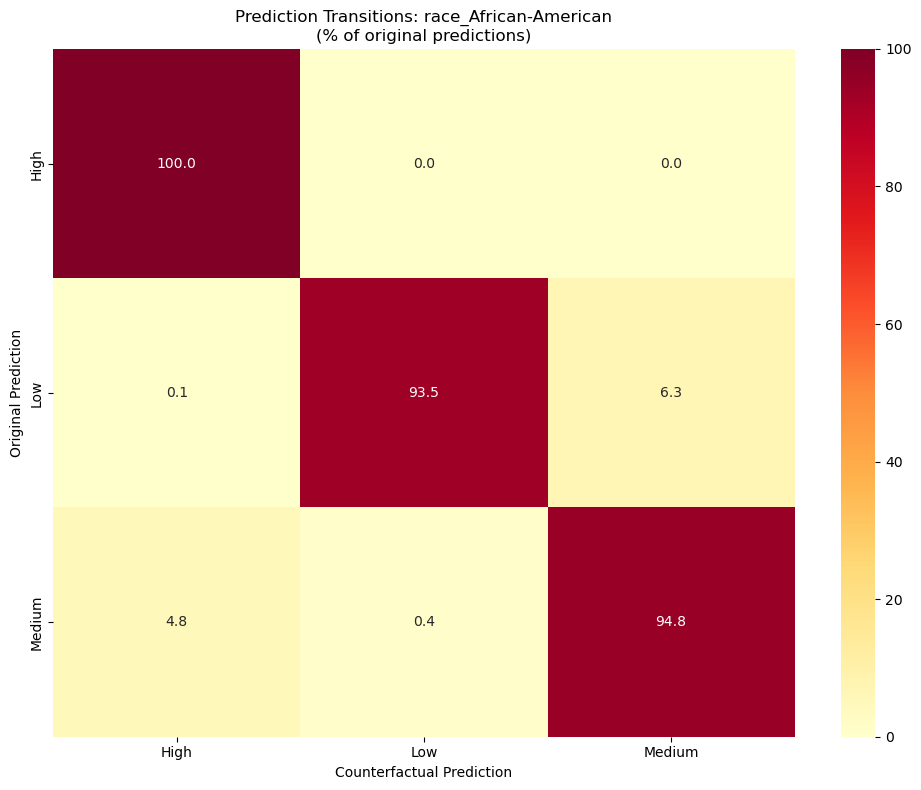


Analyzing counterfactual predictions for race_Asian...

race_Asian changes summary:
Total samples: 2165
Changed predictions: 293 (13.5%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       69.879518   0.803213  29.317269
Low                         0.000000  93.956044   6.043956
Medium                      0.217391  28.043478  71.739130


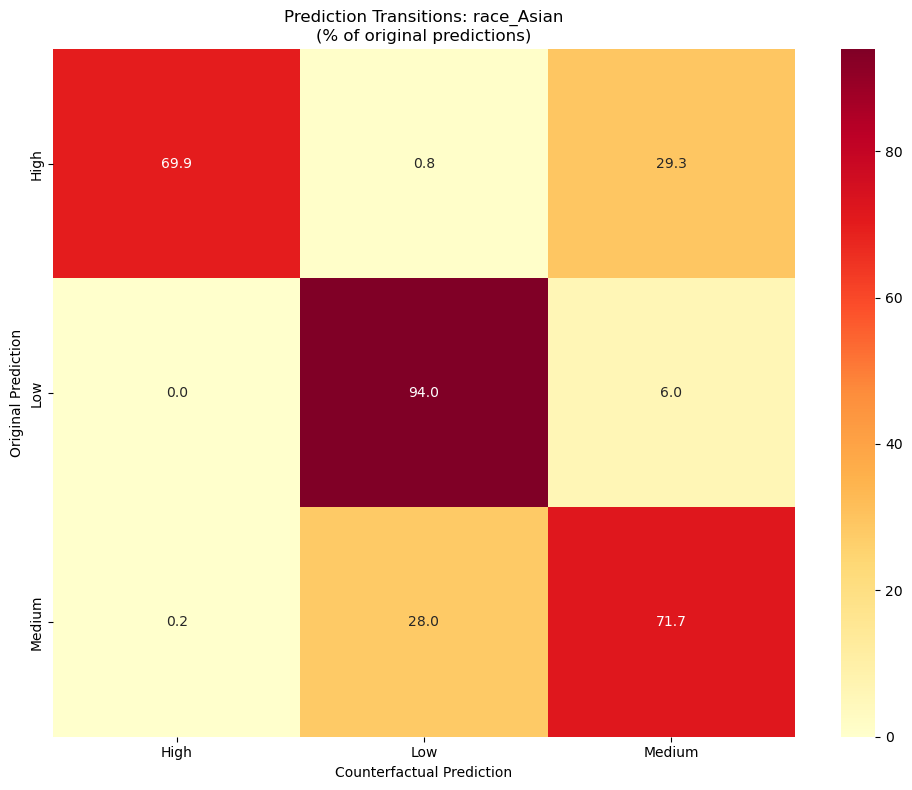


Analyzing counterfactual predictions for race_Caucasian...

race_Caucasian changes summary:
Total samples: 2165
Changed predictions: 203 (9.4%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       80.722892   0.803213  18.473896
Low                         0.000000  98.557692   1.442308
Medium                      0.434783  28.695652  70.869565


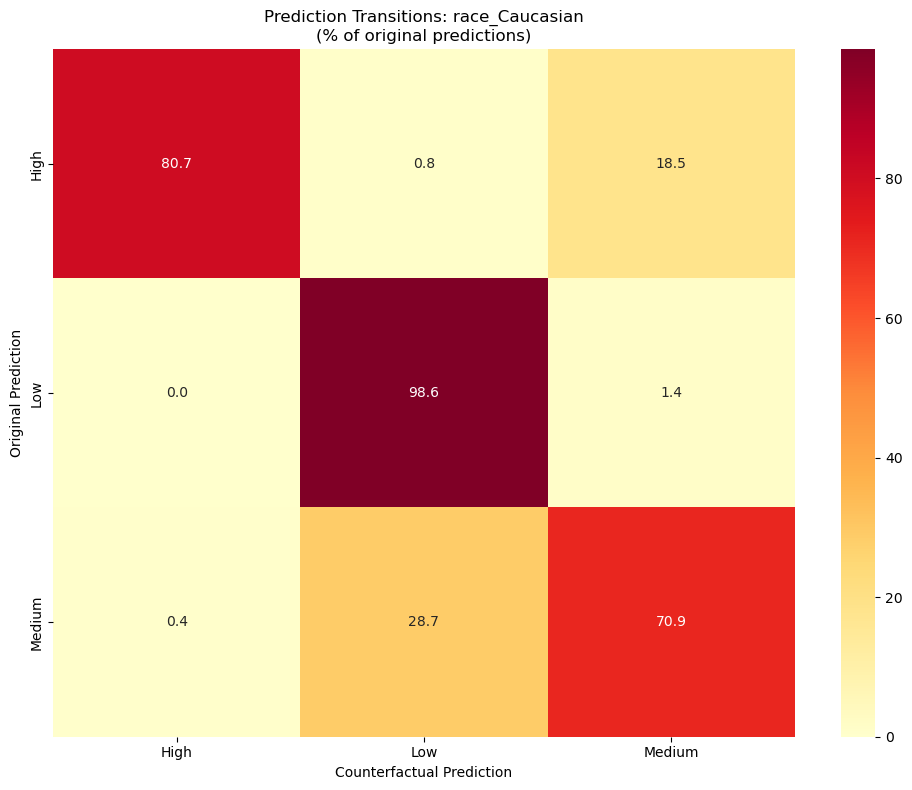


Analyzing counterfactual predictions for race_Hispanic...

race_Hispanic changes summary:
Total samples: 2165
Changed predictions: 320 (14.8%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       69.879518   2.409639  27.710843
Low                         0.000000  99.725275   0.274725
Medium                      0.217391  52.173913  47.608696


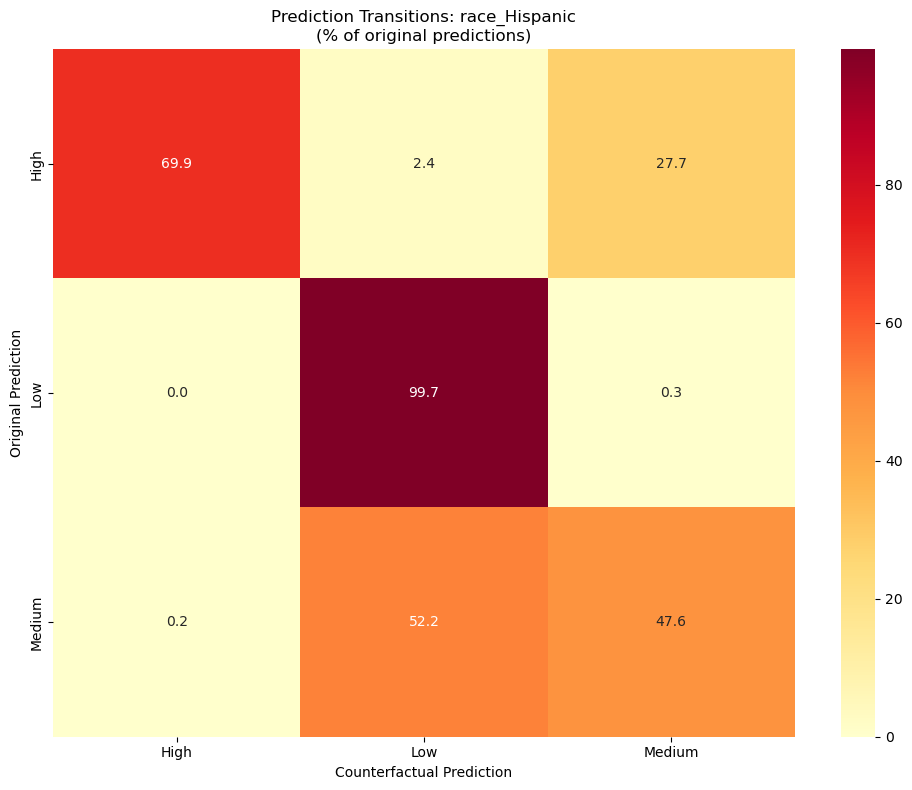


Analyzing counterfactual predictions for race_Native American...

race_Native American changes summary:
Total samples: 2165
Changed predictions: 377 (17.4%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       86.345382   0.000000  13.654618
Low                         0.000000  80.013736  19.986264
Medium                      3.695652   7.608696  88.695652


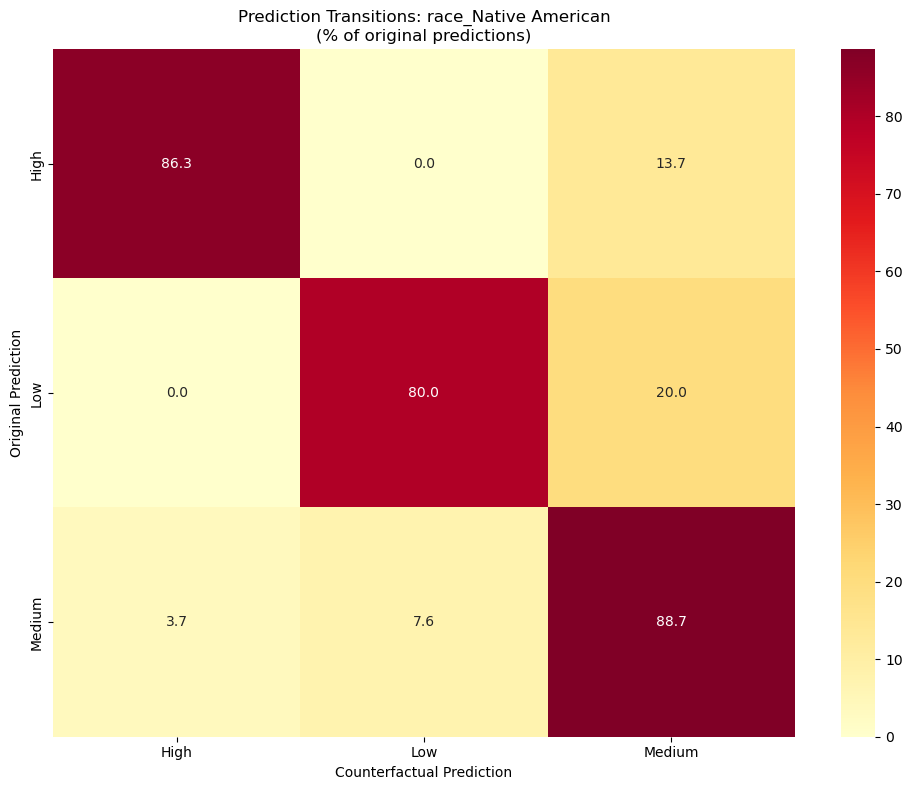


Analyzing counterfactual predictions for race_Other...

race_Other changes summary:
Total samples: 2165
Changed predictions: 428 (19.8%)

Transition matrix (%):
Counterfactual_Prediction       High        Low     Medium
Original_Prediction                                       
High                       77.108434   11.24498  11.646586
Low                         0.000000  100.00000   0.000000
Medium                      2.391304   78.26087  19.347826


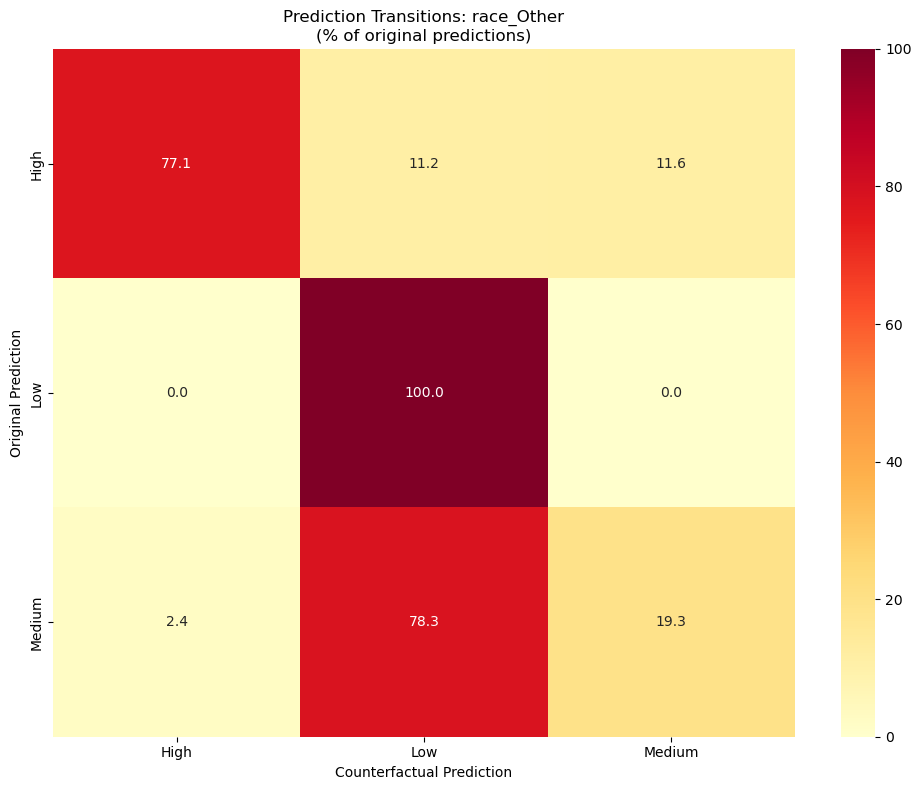


Visualizing distribution of changes...


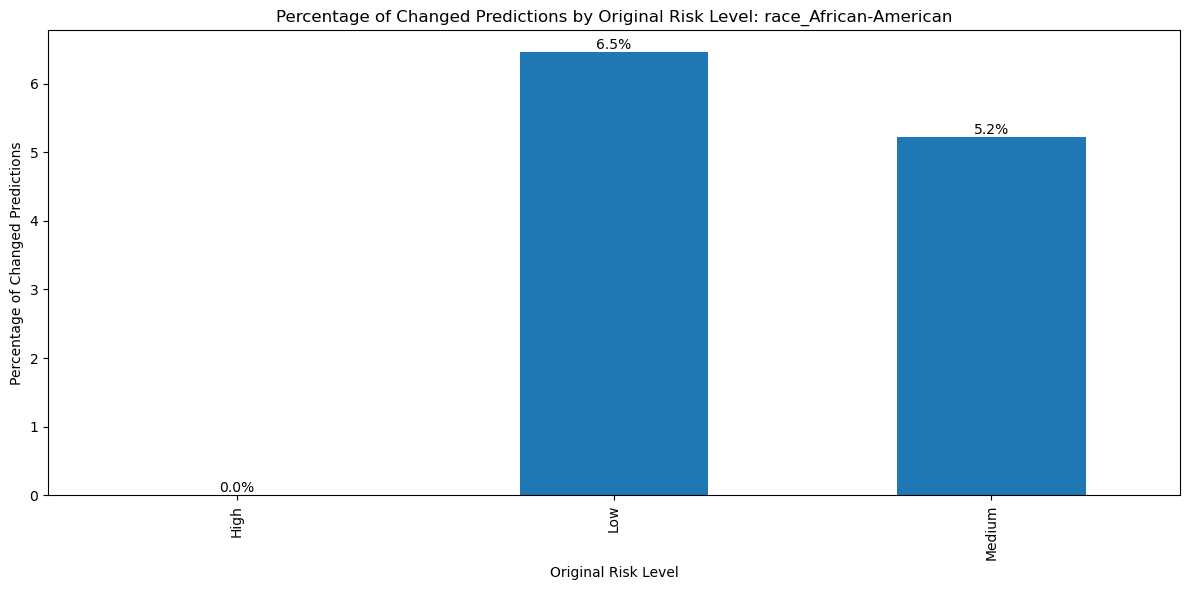

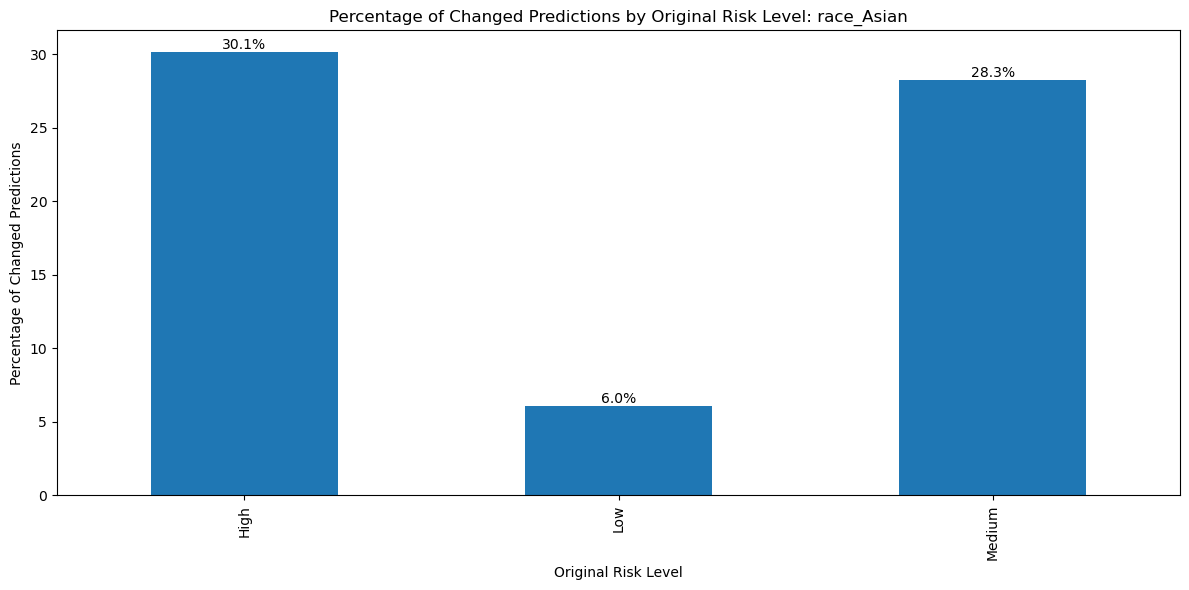

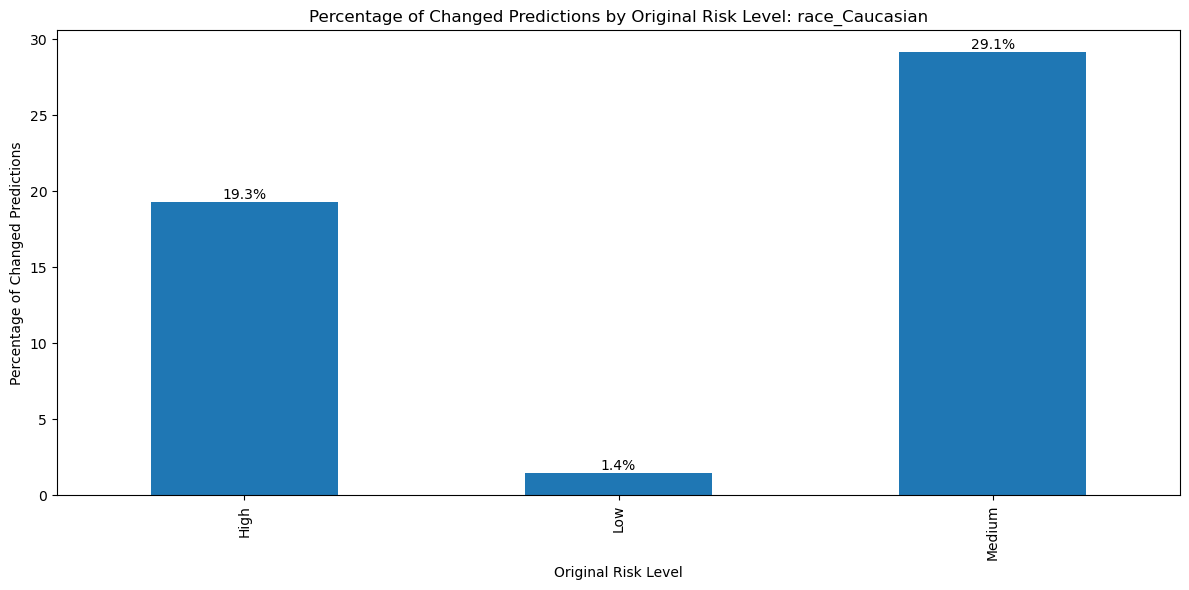

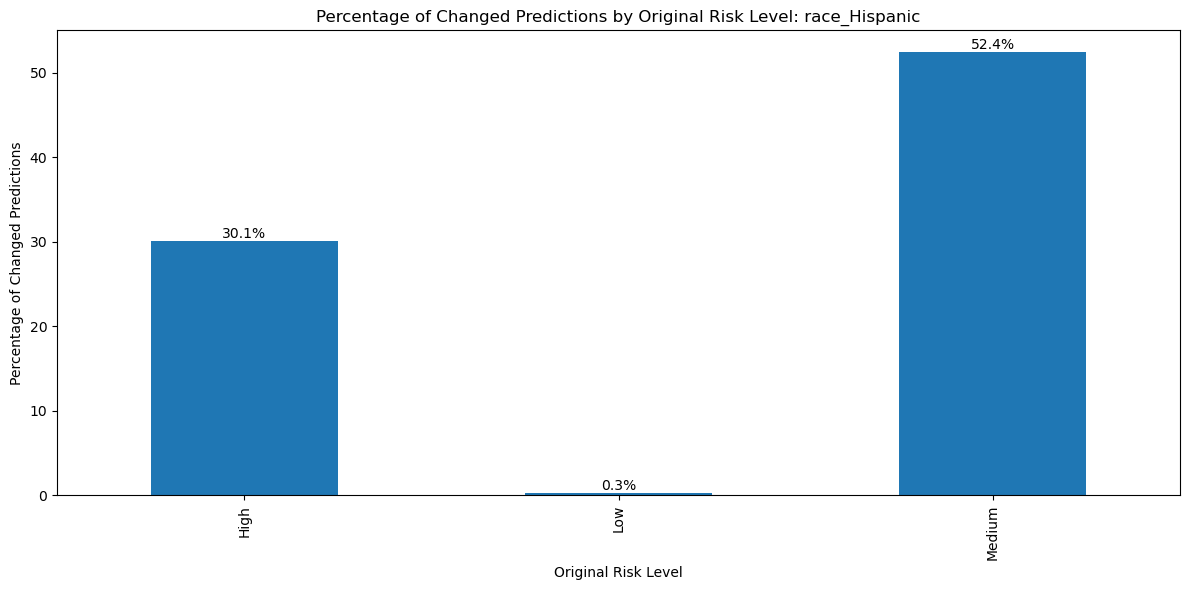

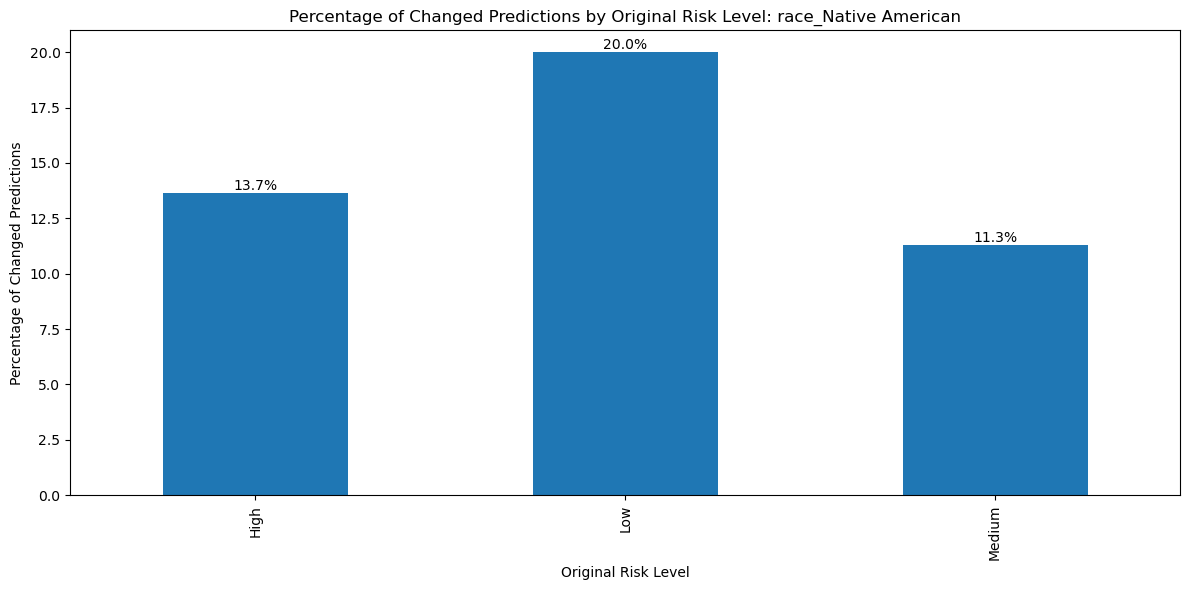

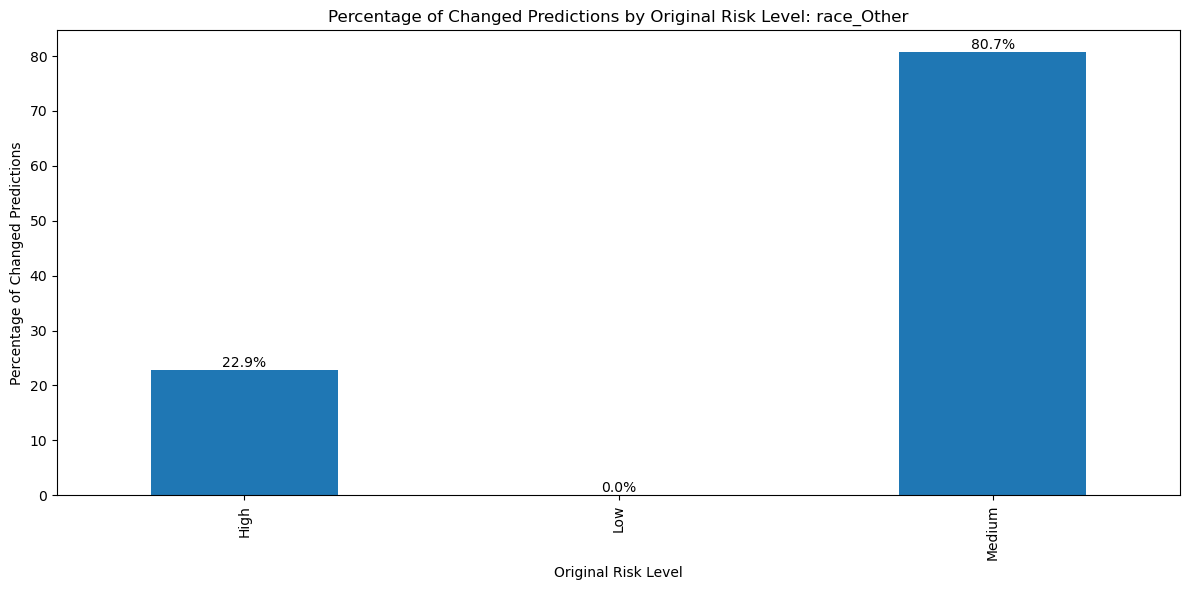

In [28]:
# Analyze transitions for race categories
race_features = [col for col in X_test.columns if col.startswith('race_')]
race_results = analyze_feature_modifications(
    best_model, X_test, 'race', race_features, race_features, le
)
plot_modification_results(race_results, 'Risk Level Distribution by Race (Modified)')

race_features = [col for col in X_test.columns if col.startswith('race_')]
for race_cat in race_features:
    print(f"\nAnalyzing counterfactual predictions for {race_cat}...")
    race_changes = create_counterfactual_predictions(best_model, X_test, race_cat, le)
    race_analysis = analyze_prediction_changes(race_changes)
    print(f"\n{race_cat} changes summary:")
    print(f"Total samples: {race_analysis['total_samples']}")
    print(f"Changed predictions: {race_analysis['changed_samples']} ({race_analysis['change_percentage']:.1f}%)")
    print("\nTransition matrix (%):")
    print(race_analysis['transitions'])
    plot_transition_matrix(race_analysis['transitions'], race_cat)

print("\nVisualizing distribution of changes...")
for race_cat in race_features:
    race_changes = create_counterfactual_predictions(best_model, X_test, race_cat, le)
    plot_change_distribution(race_changes, race_cat)